In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mm_env import SimpleEnv
import pandas as pd
from utils import evaluate, single_experiment, multiple_experiment
from dataclasses import dataclass

In [2]:
%run './all_agents.ipynb' # import all agents

In [3]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)

### Random

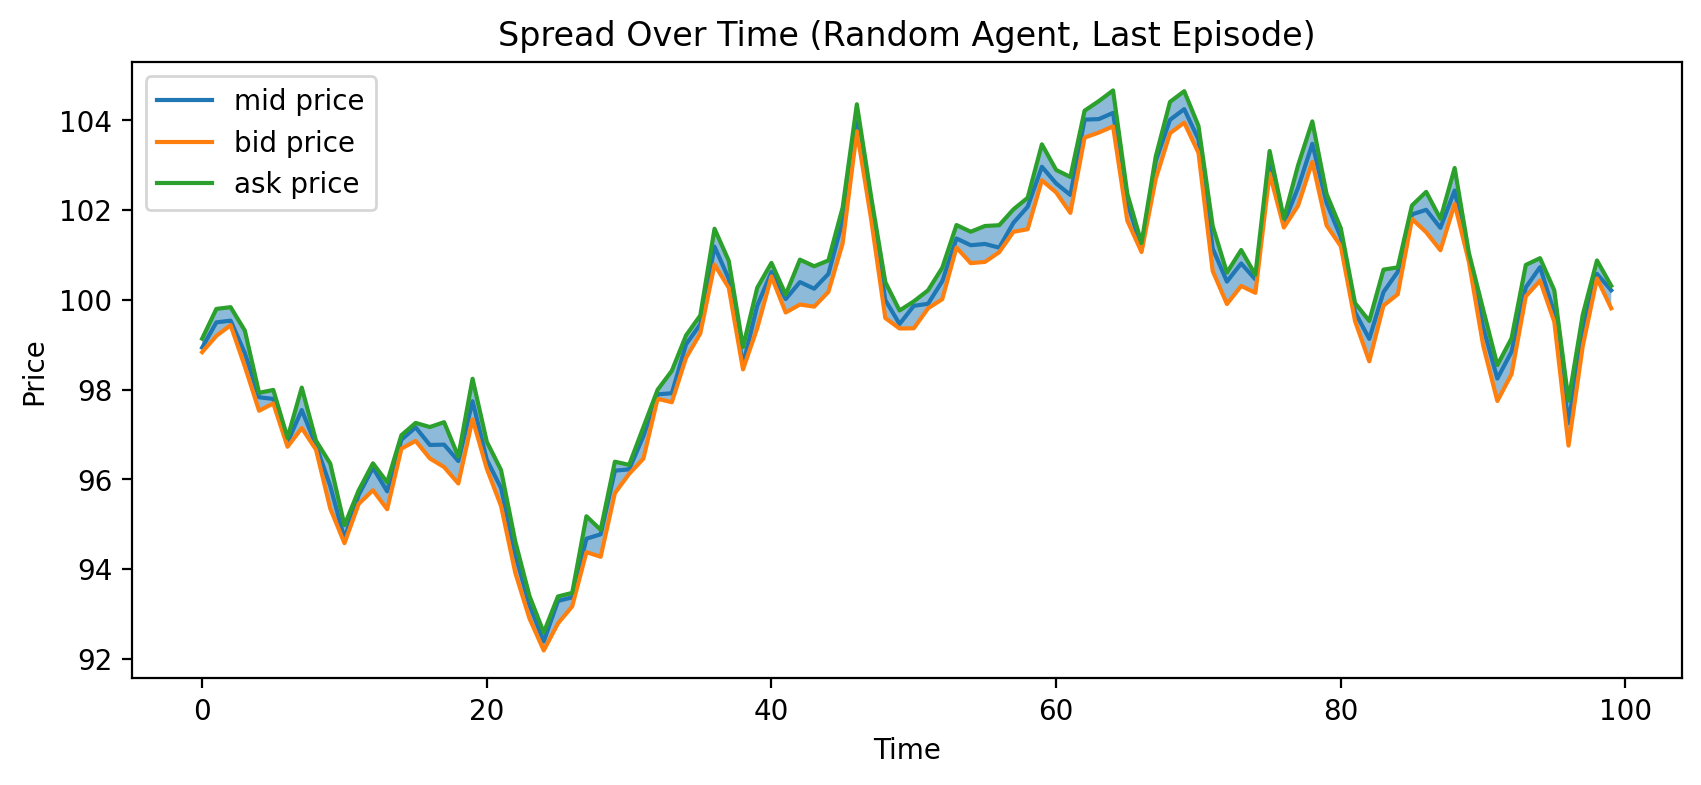

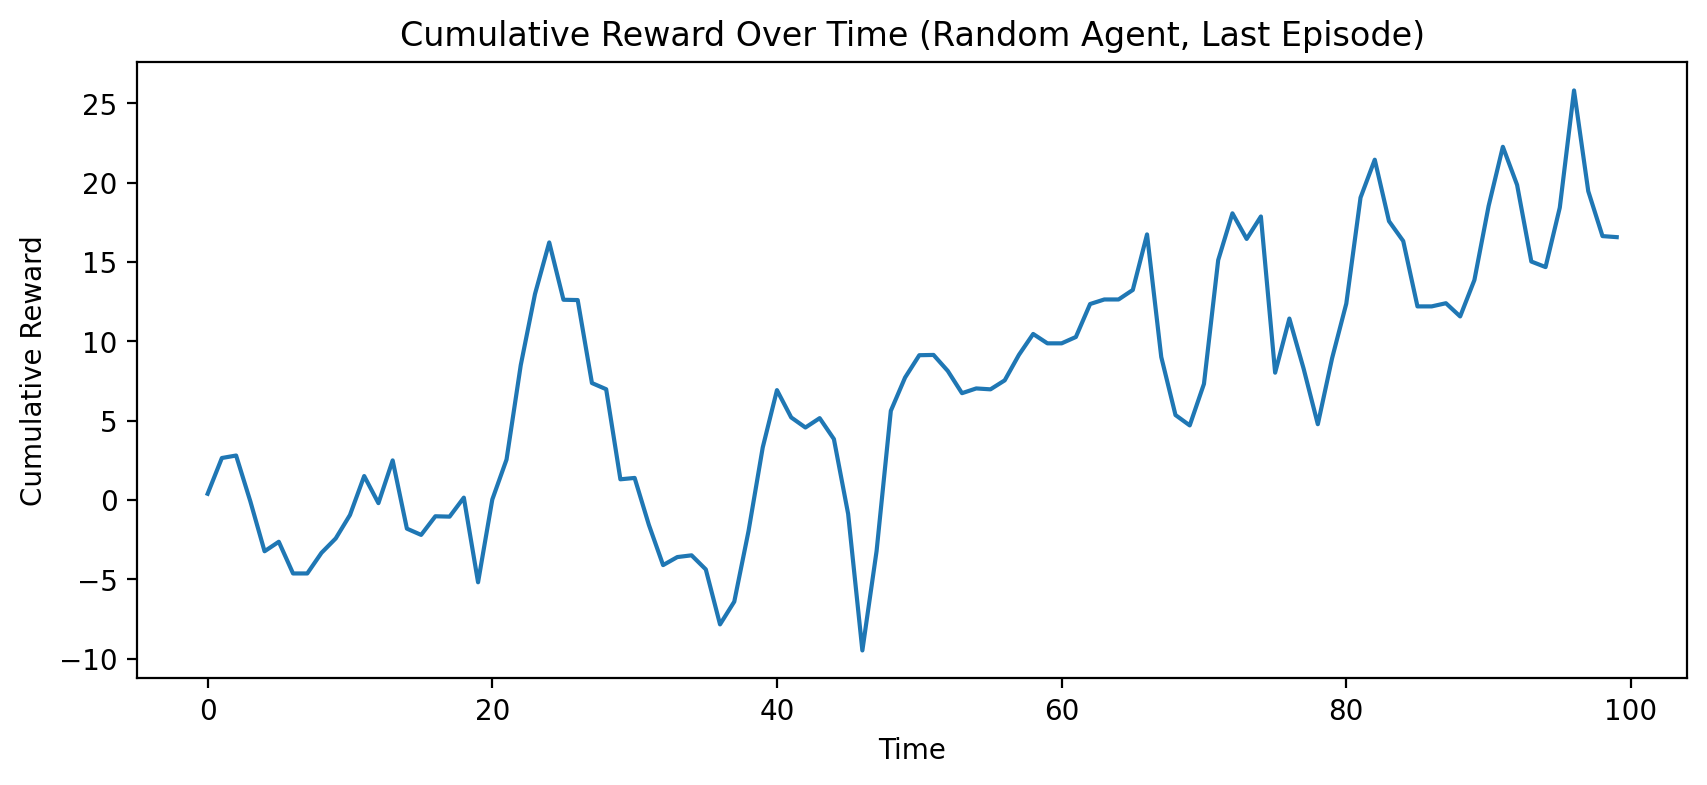

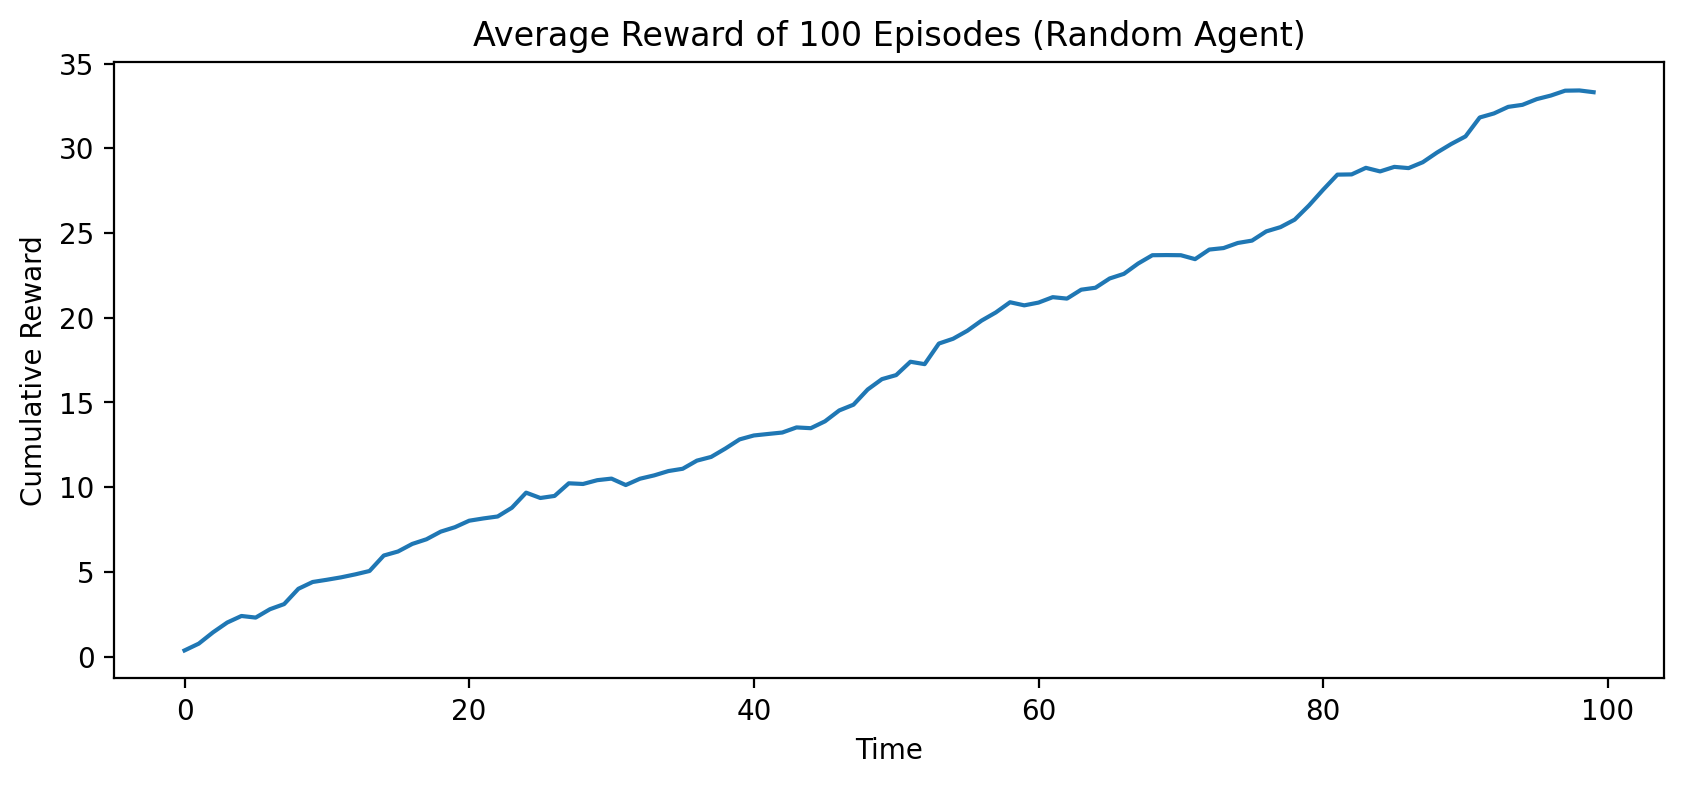

In [4]:
agent_random = RandomAgent(env_d=env.d)
logs_random, final_rewards_random, average_rewards_random = multiple_experiment(
    agent_name='Random Agent', agent=agent_random, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Q Learning

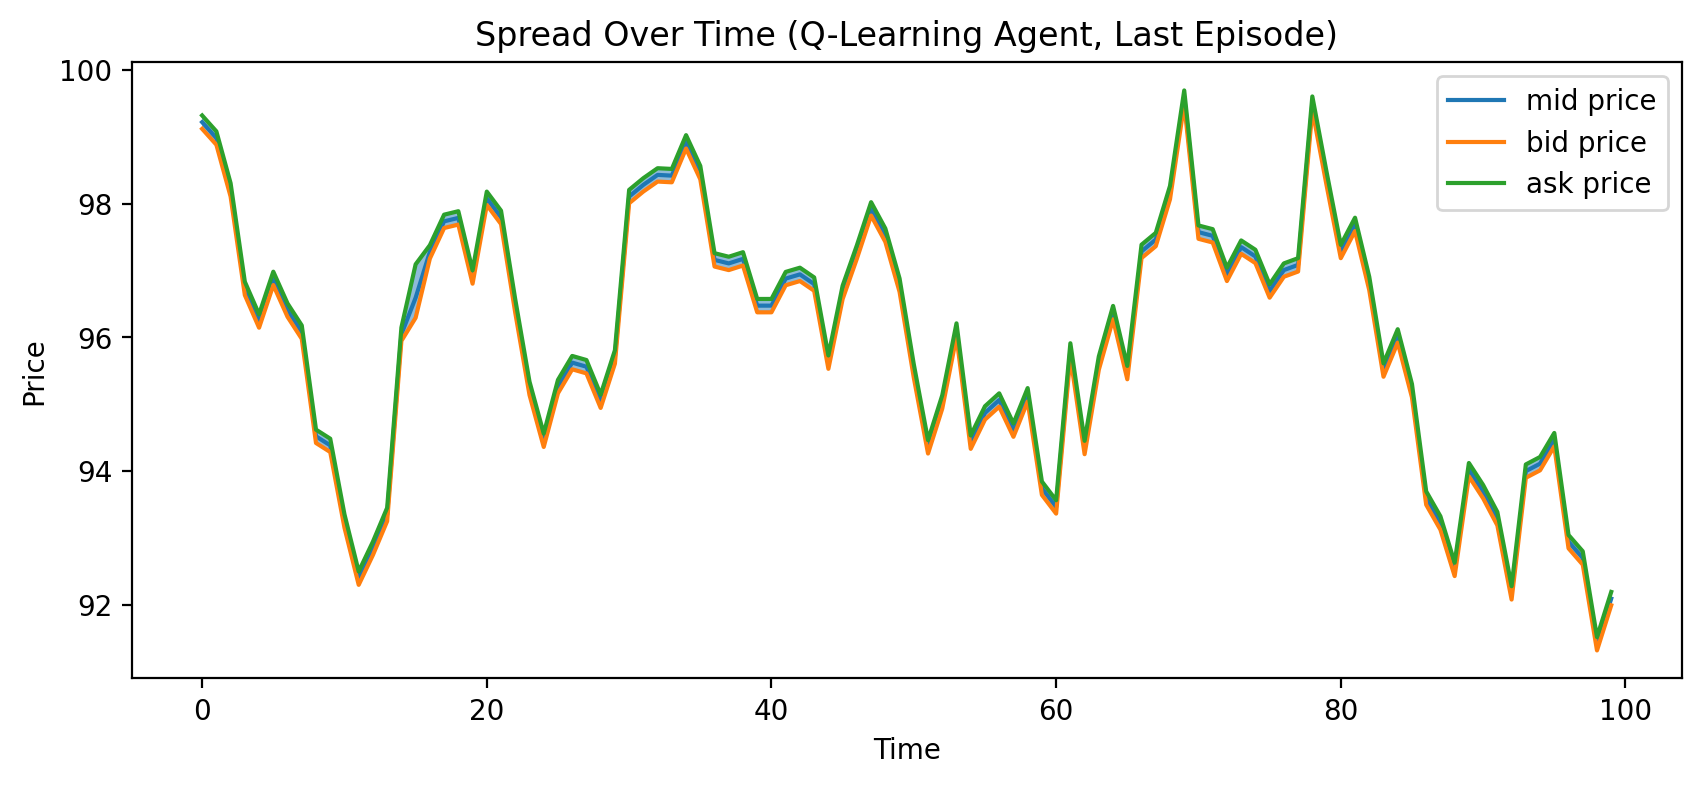

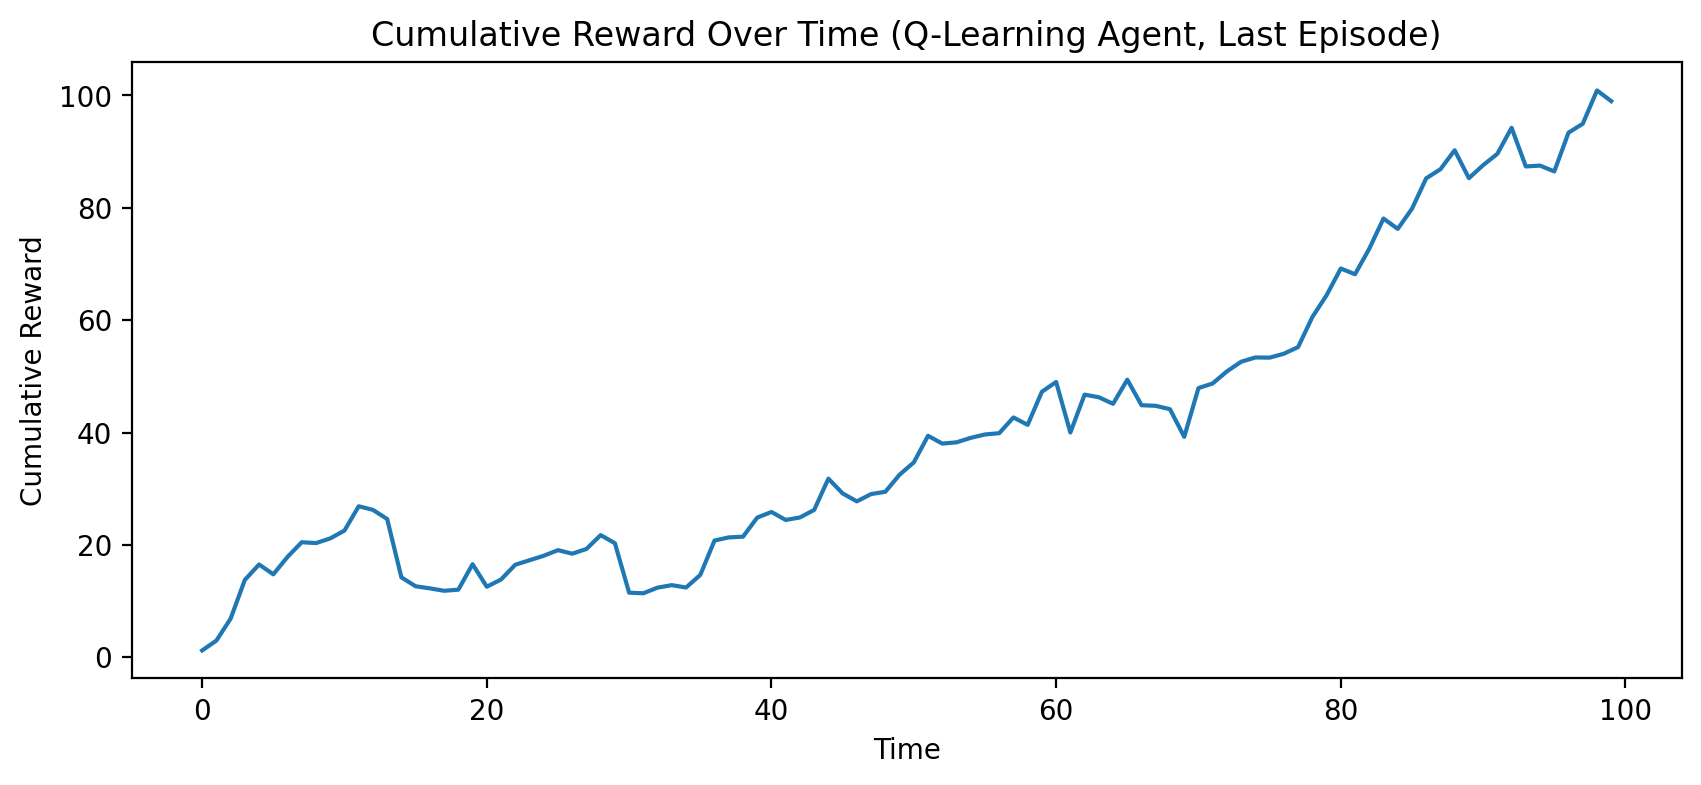

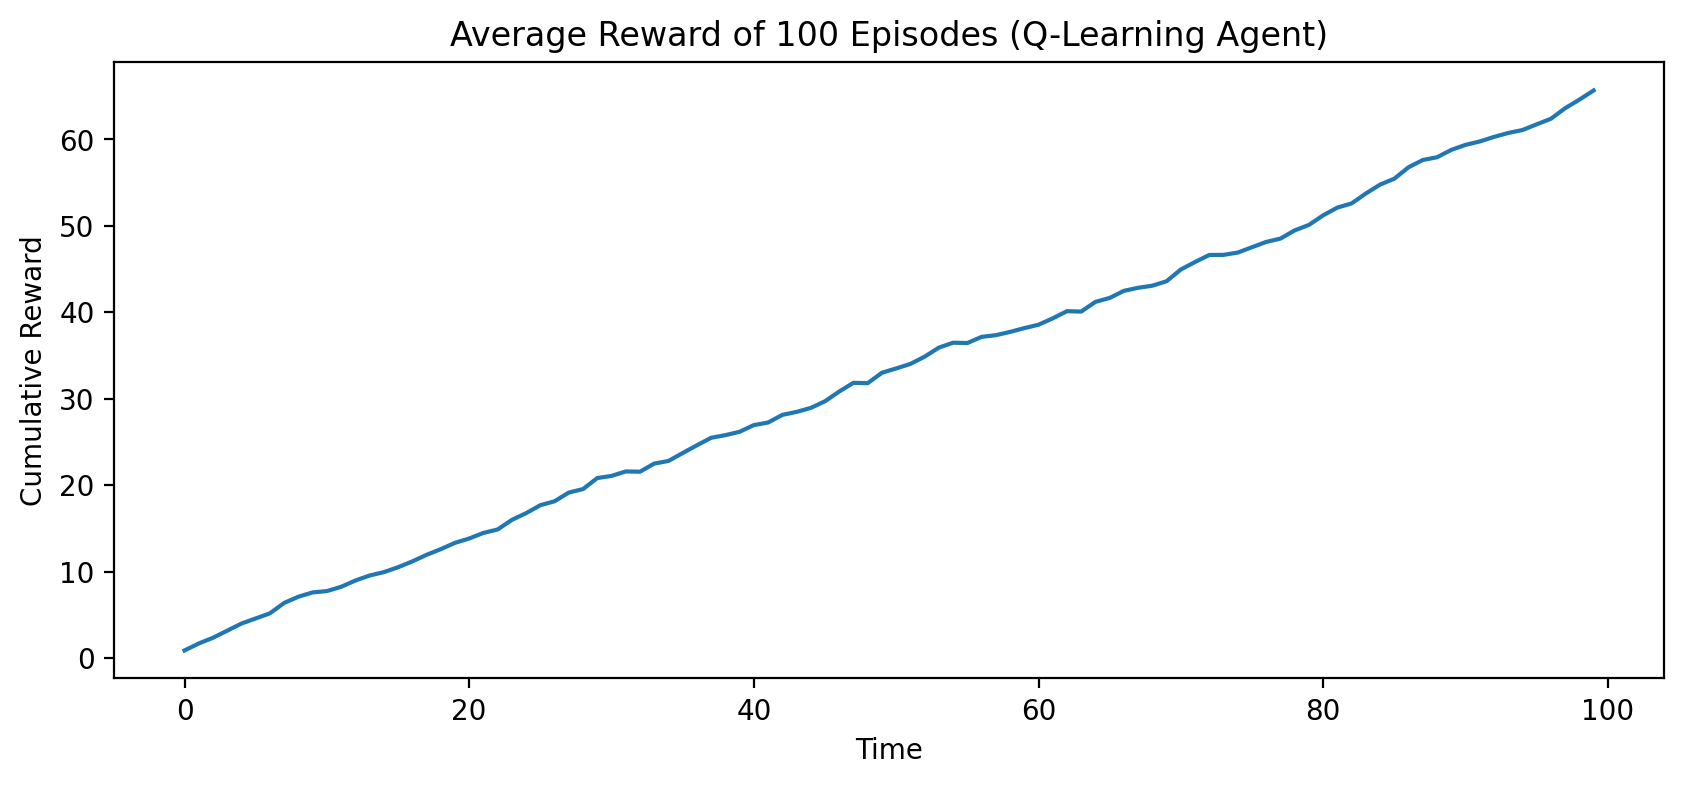

In [5]:
agent_q = QAgent(env_d=env.d, env_Q=env.Q, env_T=env.T, 
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.01)
logs_q, final_rewards_q, average_rewards_q = multiple_experiment(
    agent_name='Q-Learning Agent', agent=agent_q, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Explore First Agent

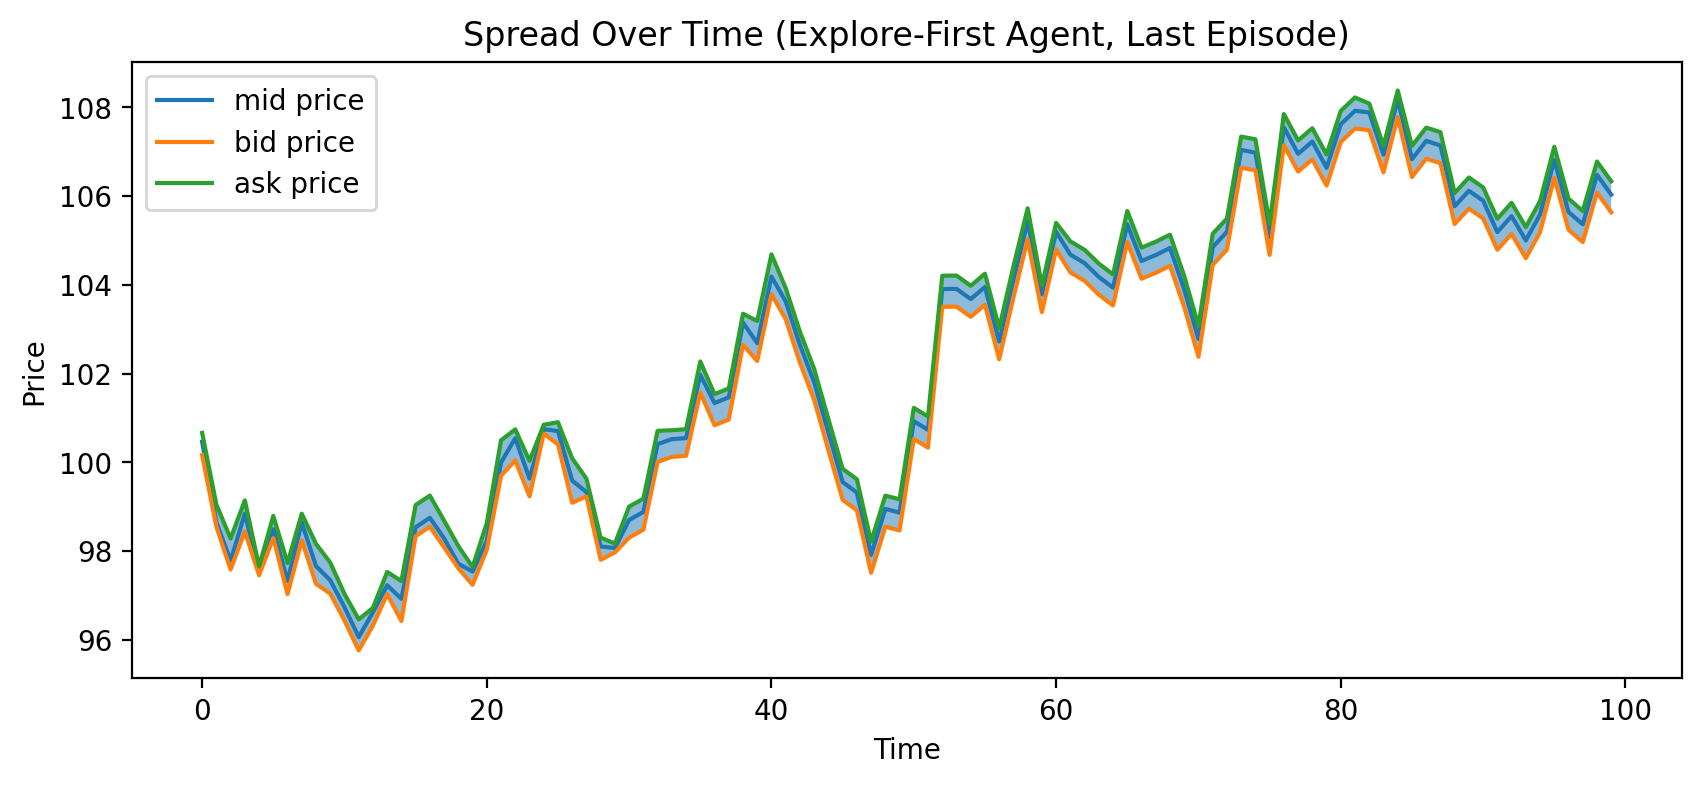

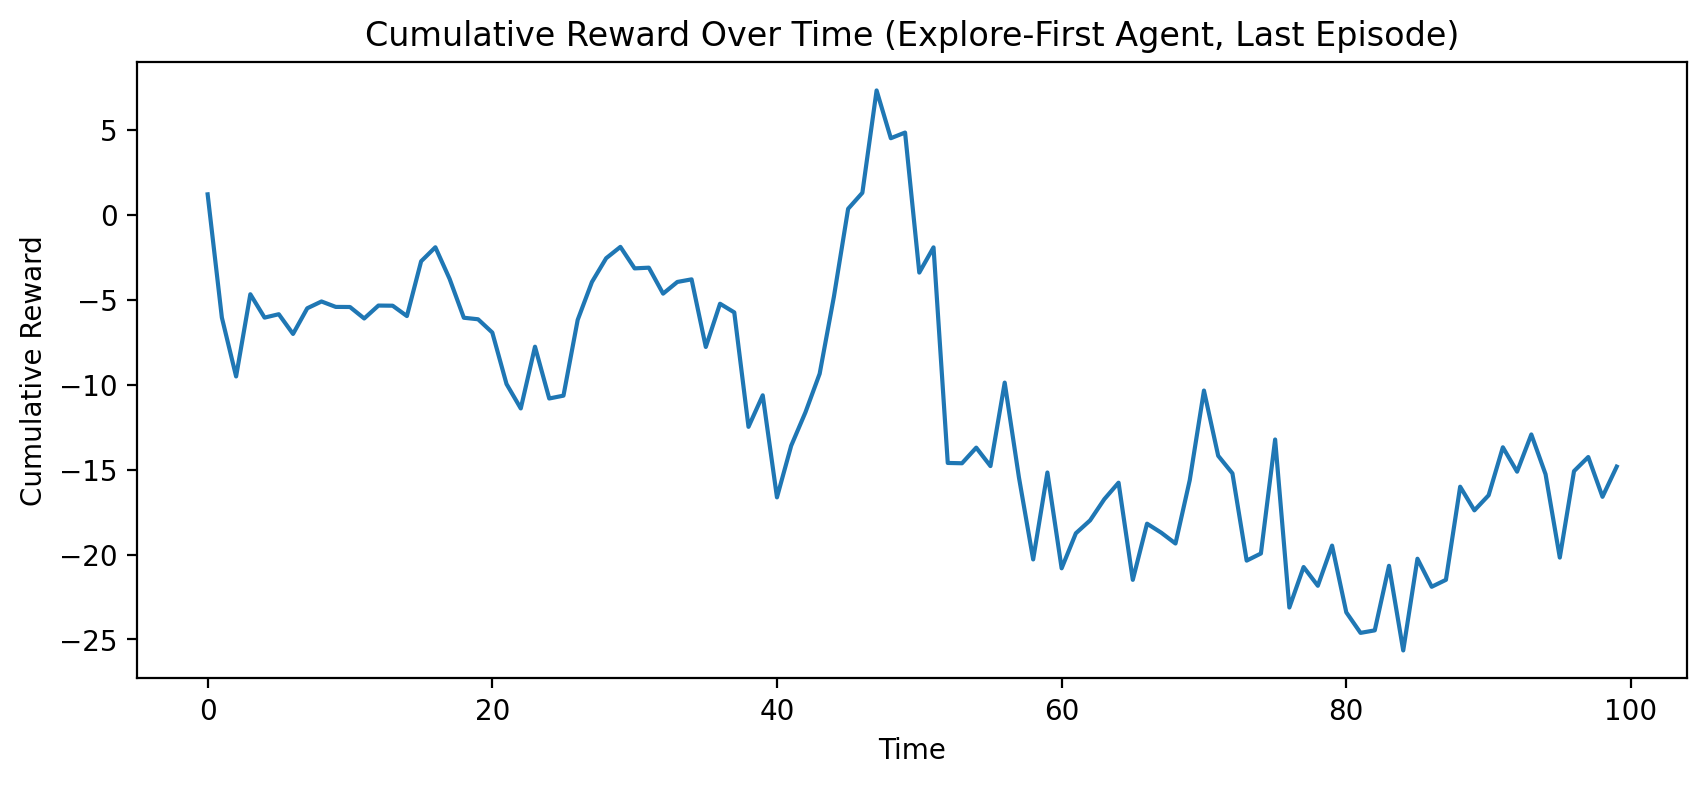

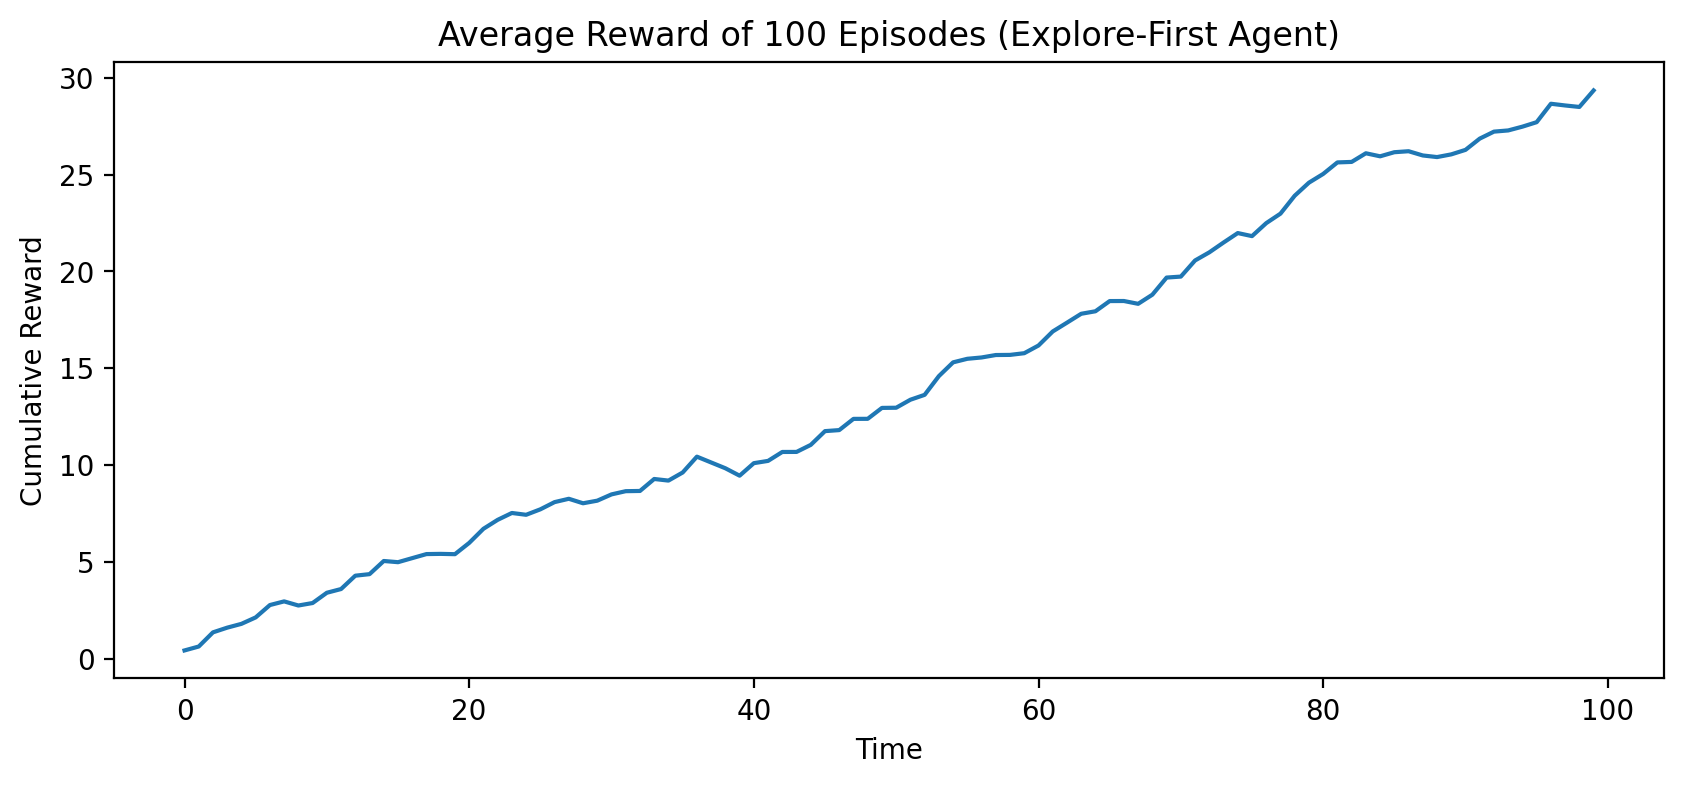

In [6]:
agent_explorefirst = ExploreFirstAgent(num_actions_bid=env.d, num_actions_ask=env.d, max_explore=30)
logs_ef, final_rewards_ef, average_rewards_ef = multiple_experiment(
    agent_name='Explore-First Agent', agent=agent_explorefirst, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### UCB Agent

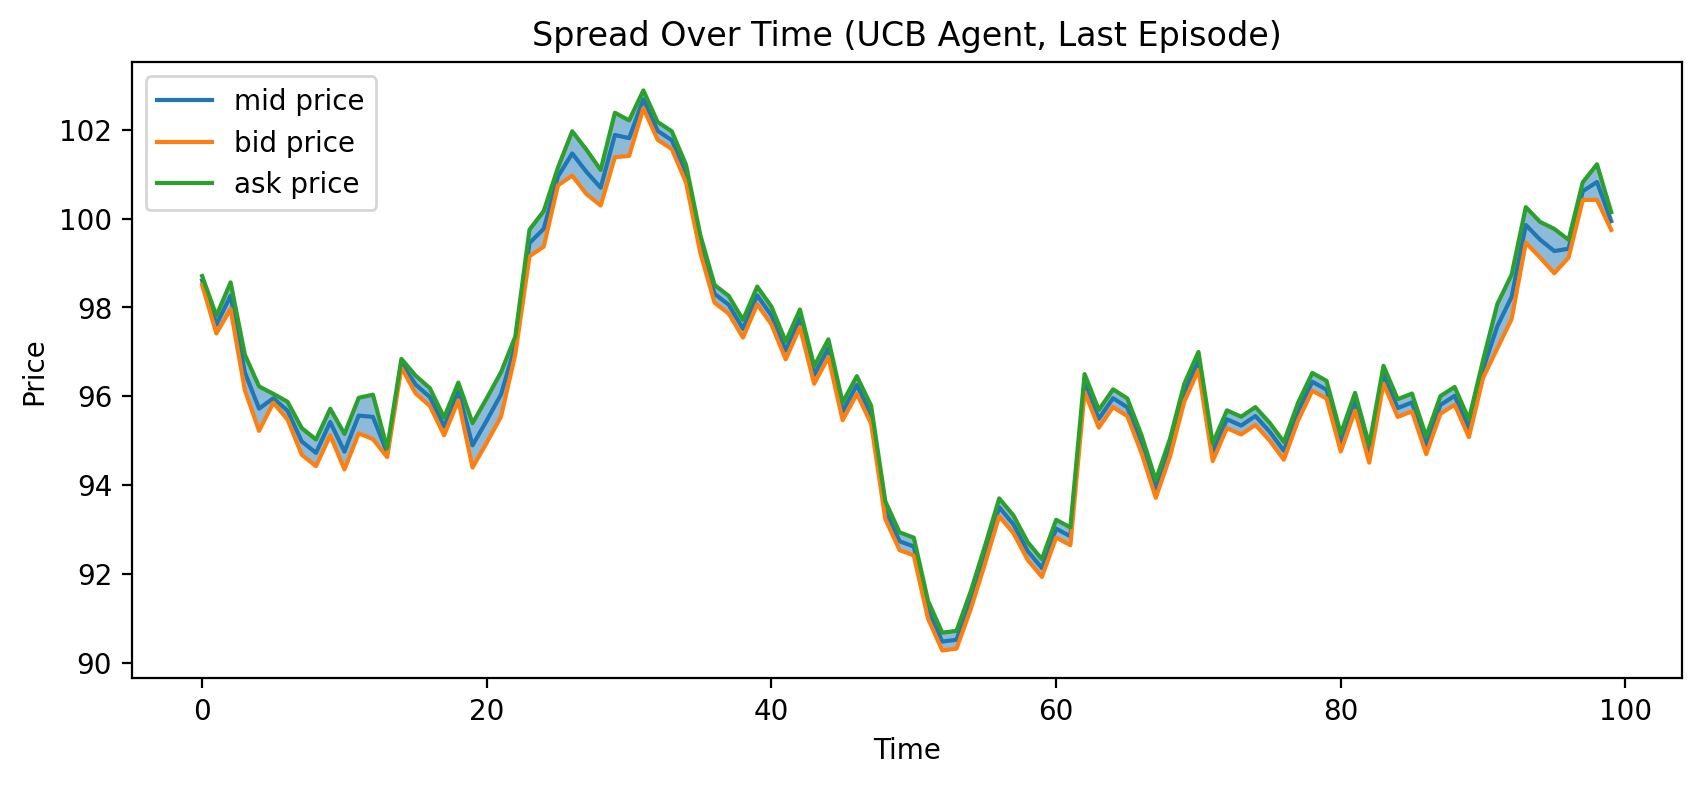

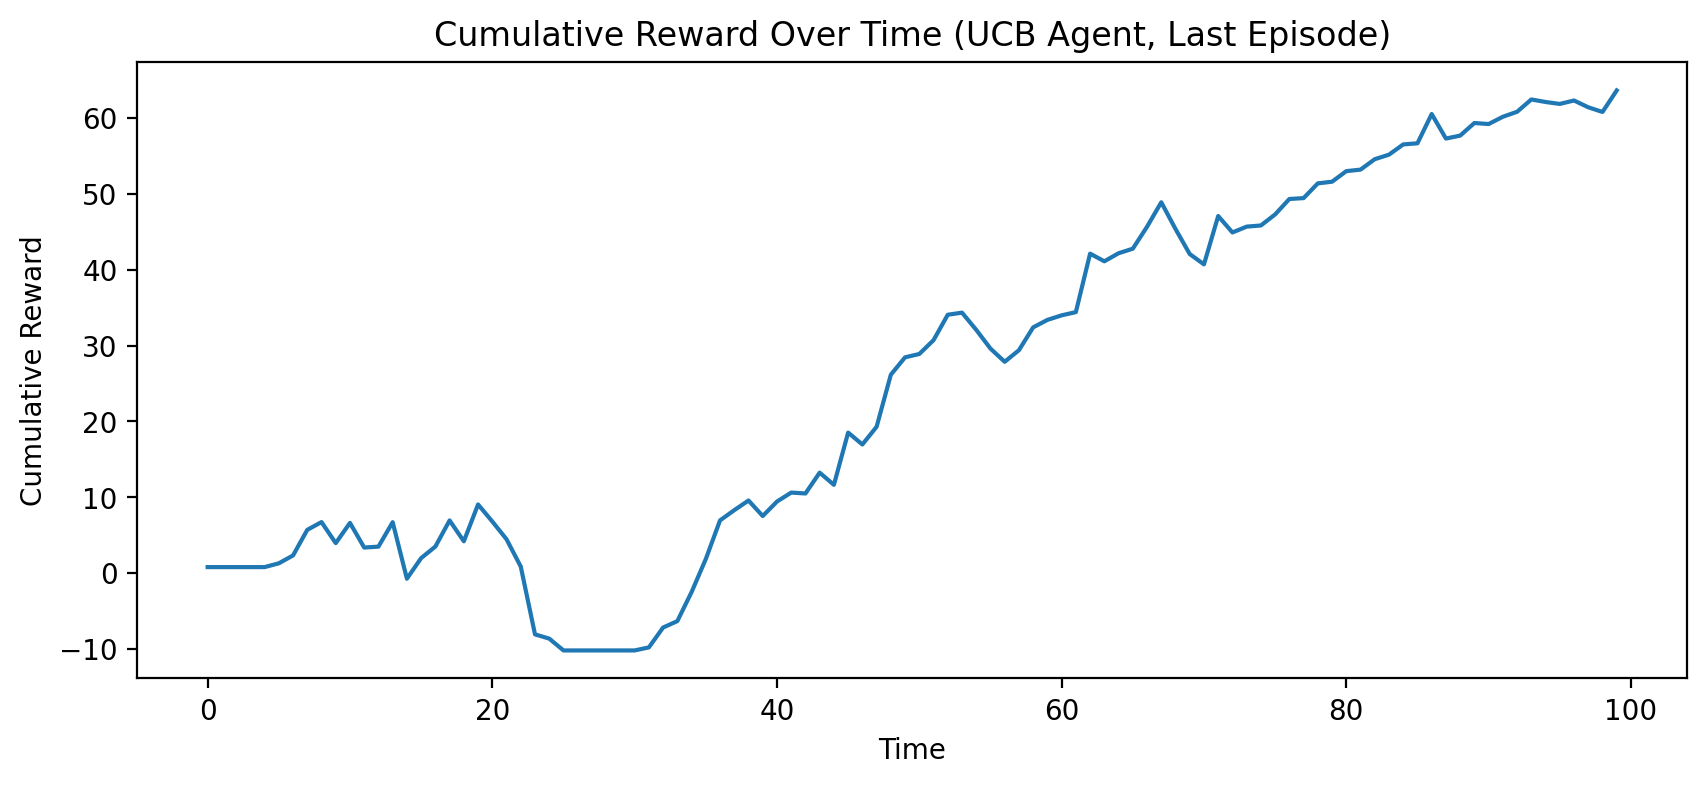

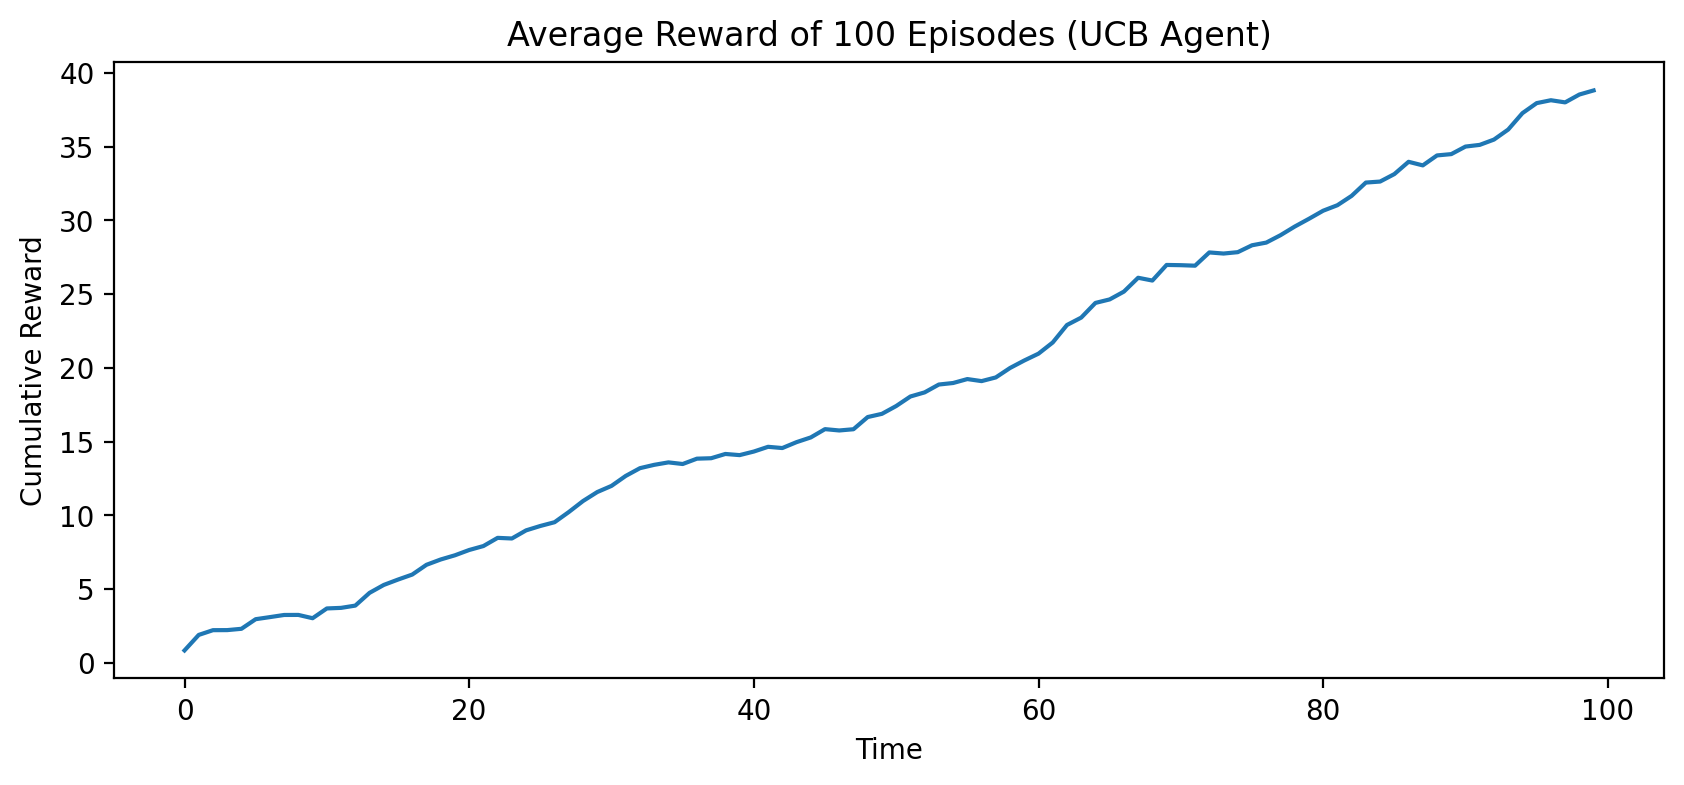

In [7]:
agent_ucb = UCBAgent(num_actions_bid=env.d, num_actions_ask=env.d)
logs_ucb, final_rewards_ucb, average_rewards_ucb = multiple_experiment(
    agent_name='UCB Agent', agent=agent_ucb, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Epsilon-Greedy Agent

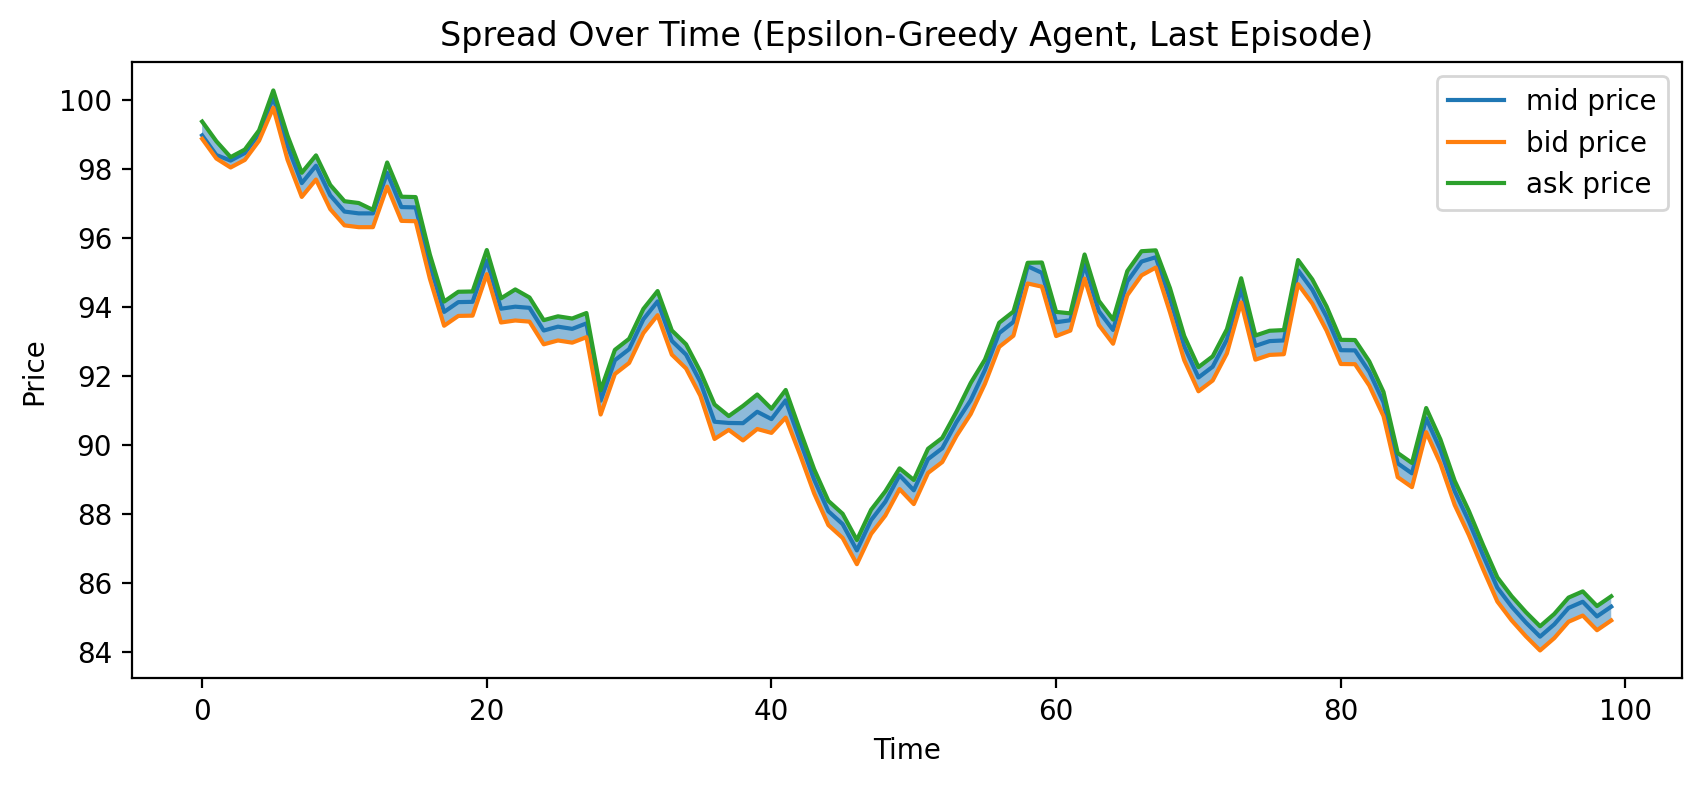

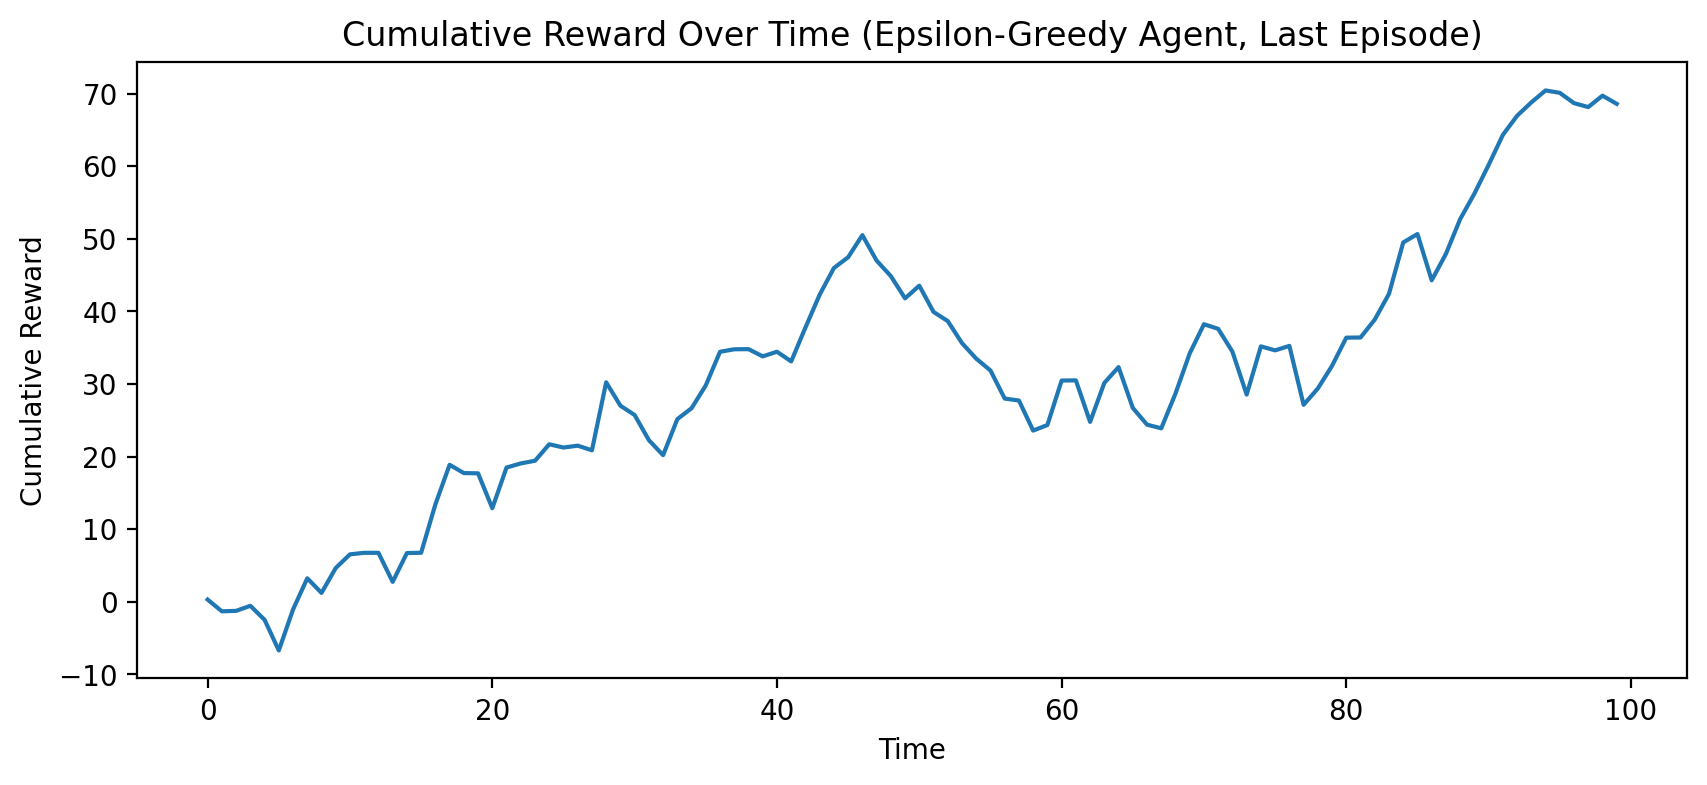

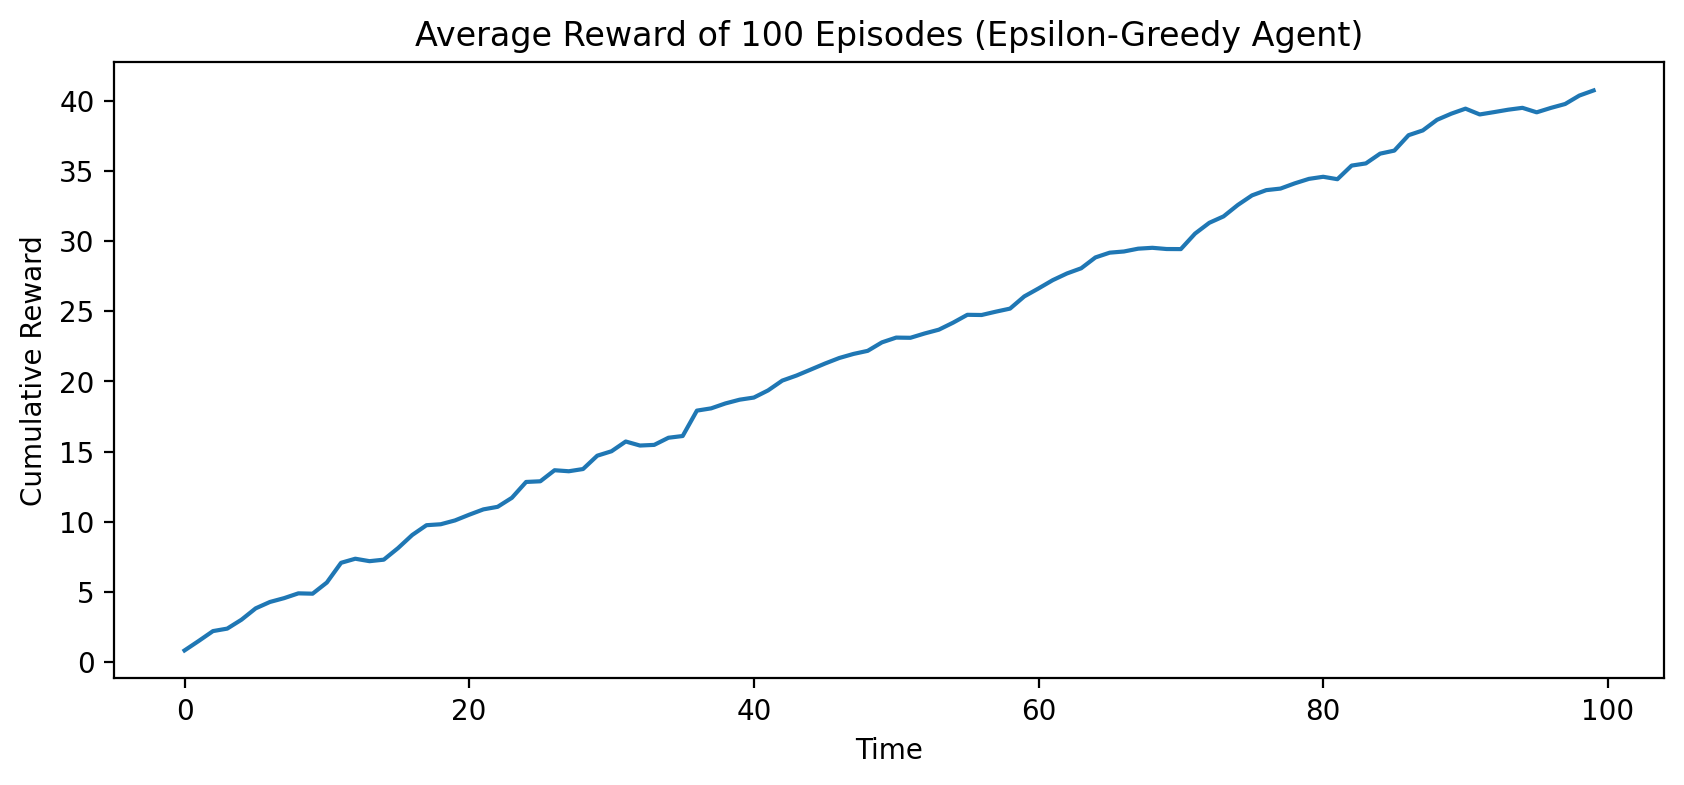

In [8]:
agent_epsilongreedy = EpsilonGreedyAgent(num_actions_bid=env.d, num_actions_ask=env.d, epsilon=0.1)
logs_eg, final_rewards_eg, average_rewards_eg = multiple_experiment(
    agent_name='Epsilon-Greedy Agent', agent=agent_epsilongreedy, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Decay-Epsilon-Greedy Agent

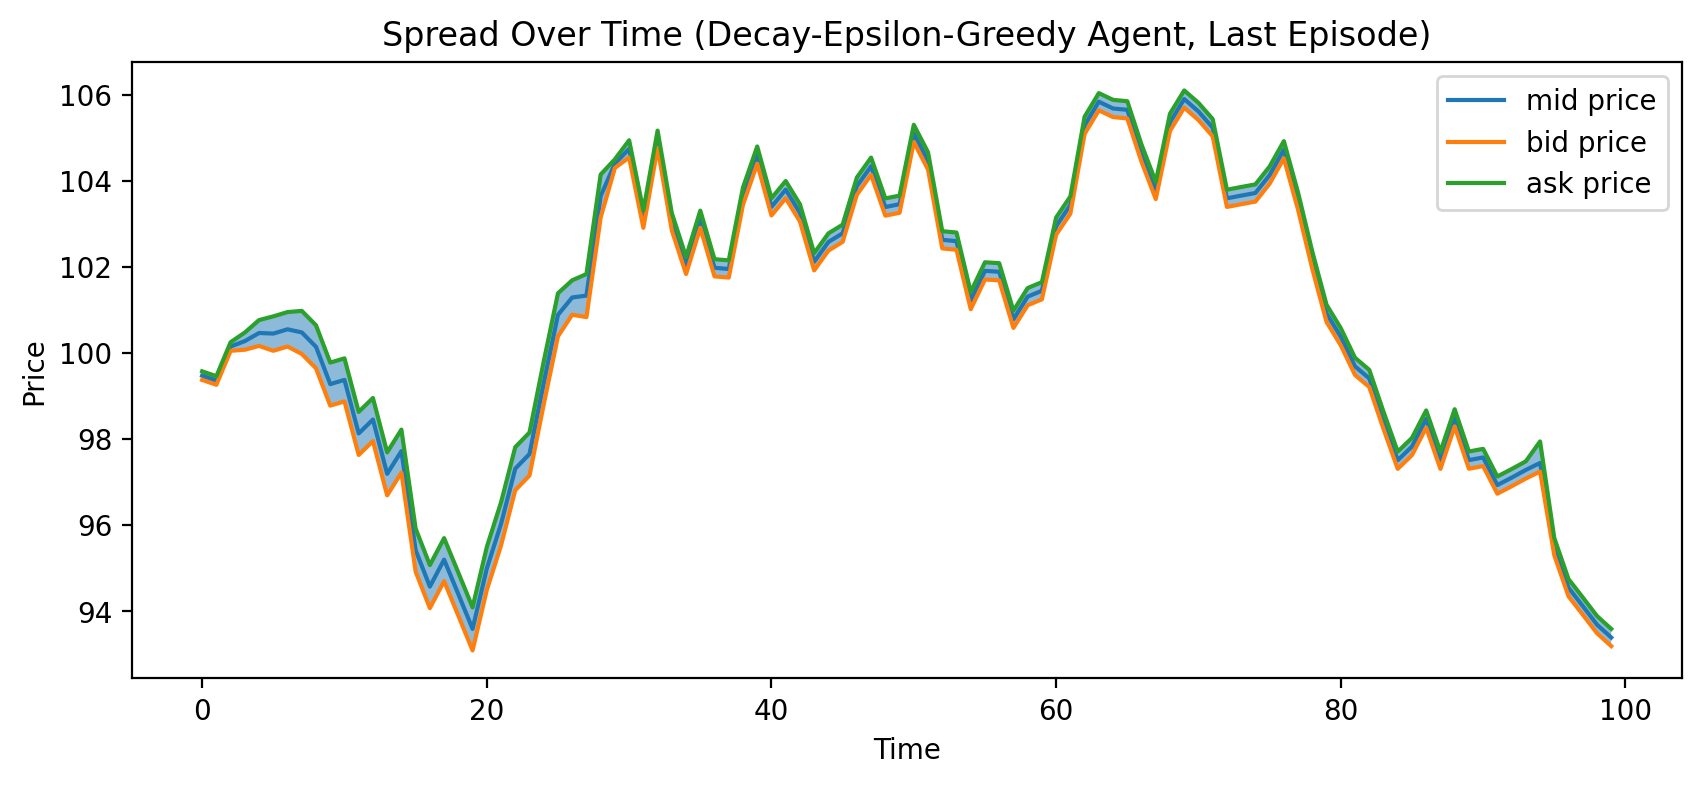

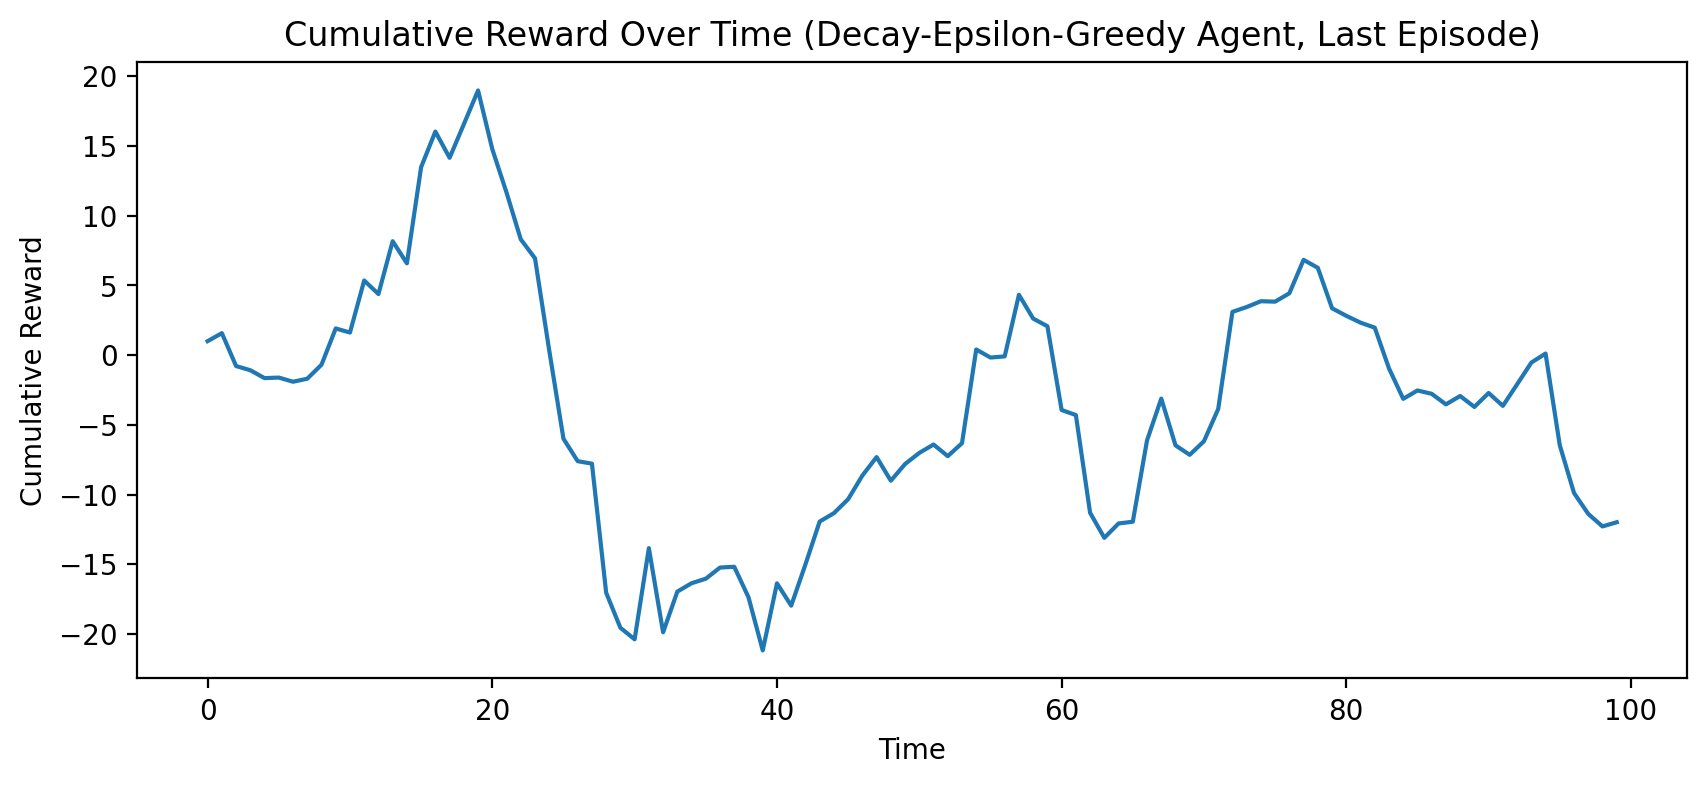

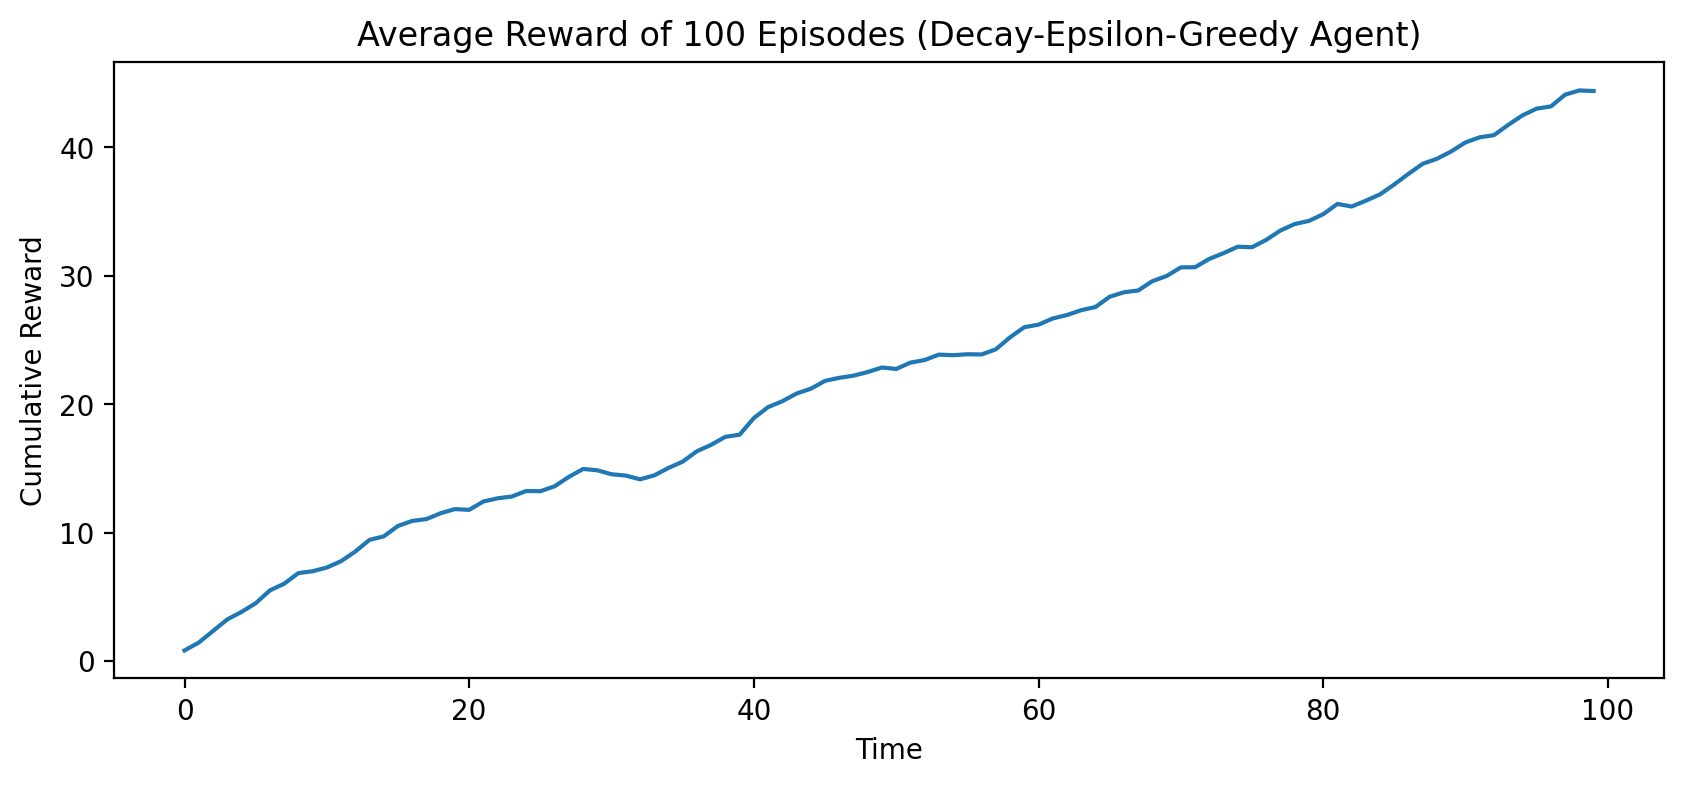

In [9]:
agent_decayepsilongreedy = DecayEpsilonGreedyAgent(num_actions_bid=env.d, num_actions_ask=env.d, 
                                                   epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.01)
logs_deg, final_rewards_deg, average_rewards_deg = multiple_experiment(
    agent_name='Decay-Epsilon-Greedy Agent', agent=agent_decayepsilongreedy, env=env, num_episodes=100,
    show_each=False, show_last=True, show_average=True)

## Optimal

In [10]:
agent_optimal = OptimalAgent(env)

/opt/homebrew/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/megijaupi/Documents/MIT/fall2022/optimalMM/mm_env.py:275: RuntimeWarning: invalid value encountered in scalar add
  delta_neg = 1 / self.kappa - h[self.Q_t + self.Q + 1] + h[self.Q_t + self.Q]
/Users/megijaupi/Documents/MIT/fall2022/optimalMM/mm_env.py:269: RuntimeWarning: overflow encountered in matmul
  omega = np.matmul(expm(self.A * (self.T - self.t)), self.z)
/Users/megijaupi/Documents/MIT/fall2022/optimalMM/mm_env.py:273: RuntimeWarning: invalid value encountered in scalar add
  delta_pos = 1 / self.kappa - h[self.Q_t + self.Q - 1] + h[self.Q_t + self.Q]


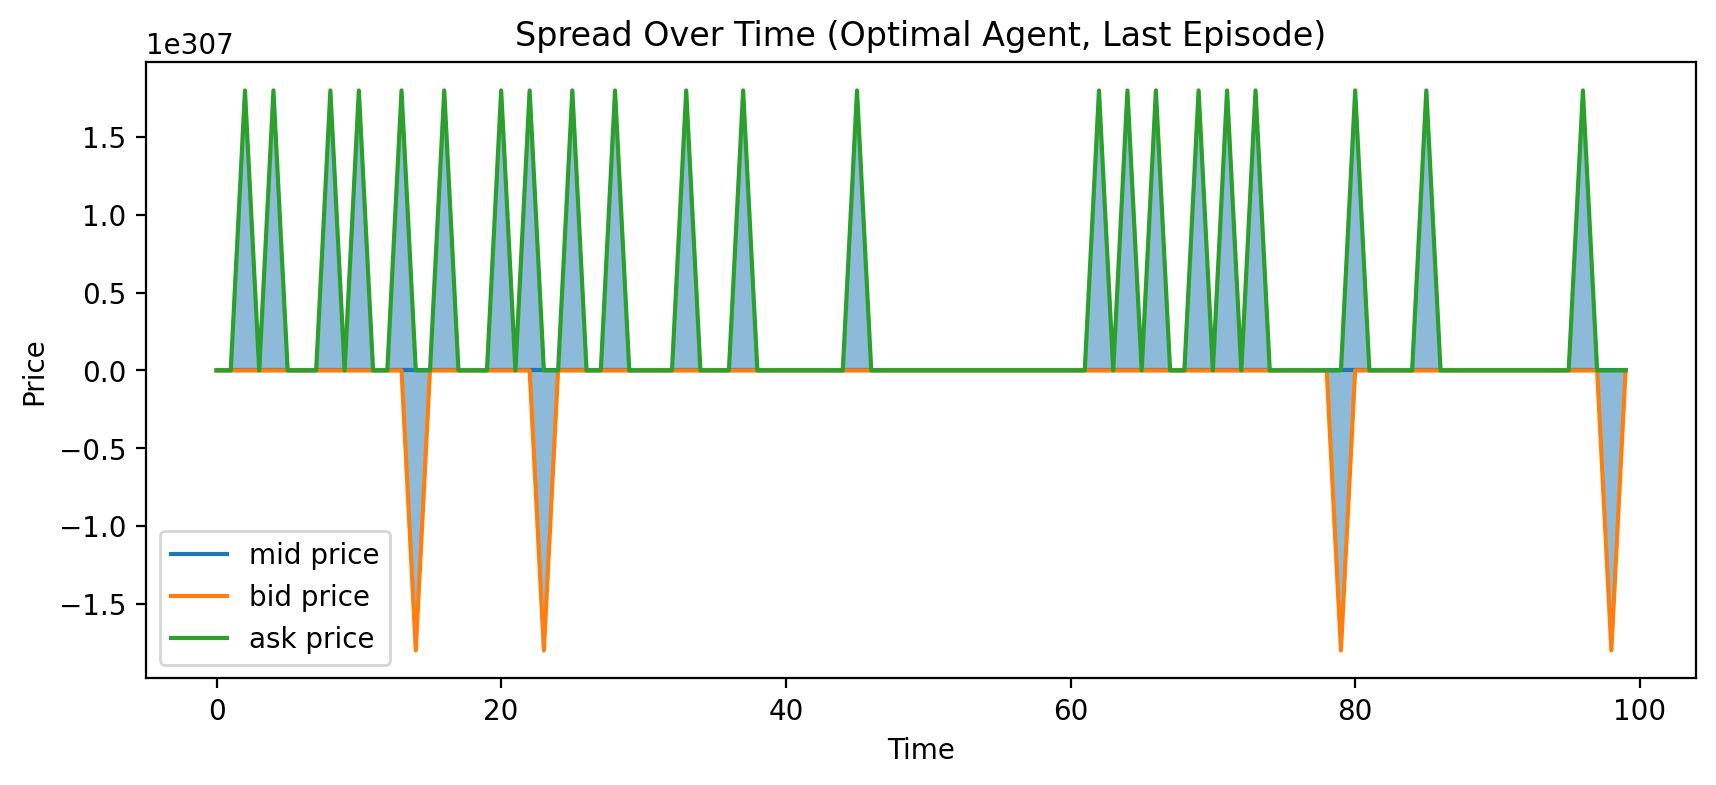

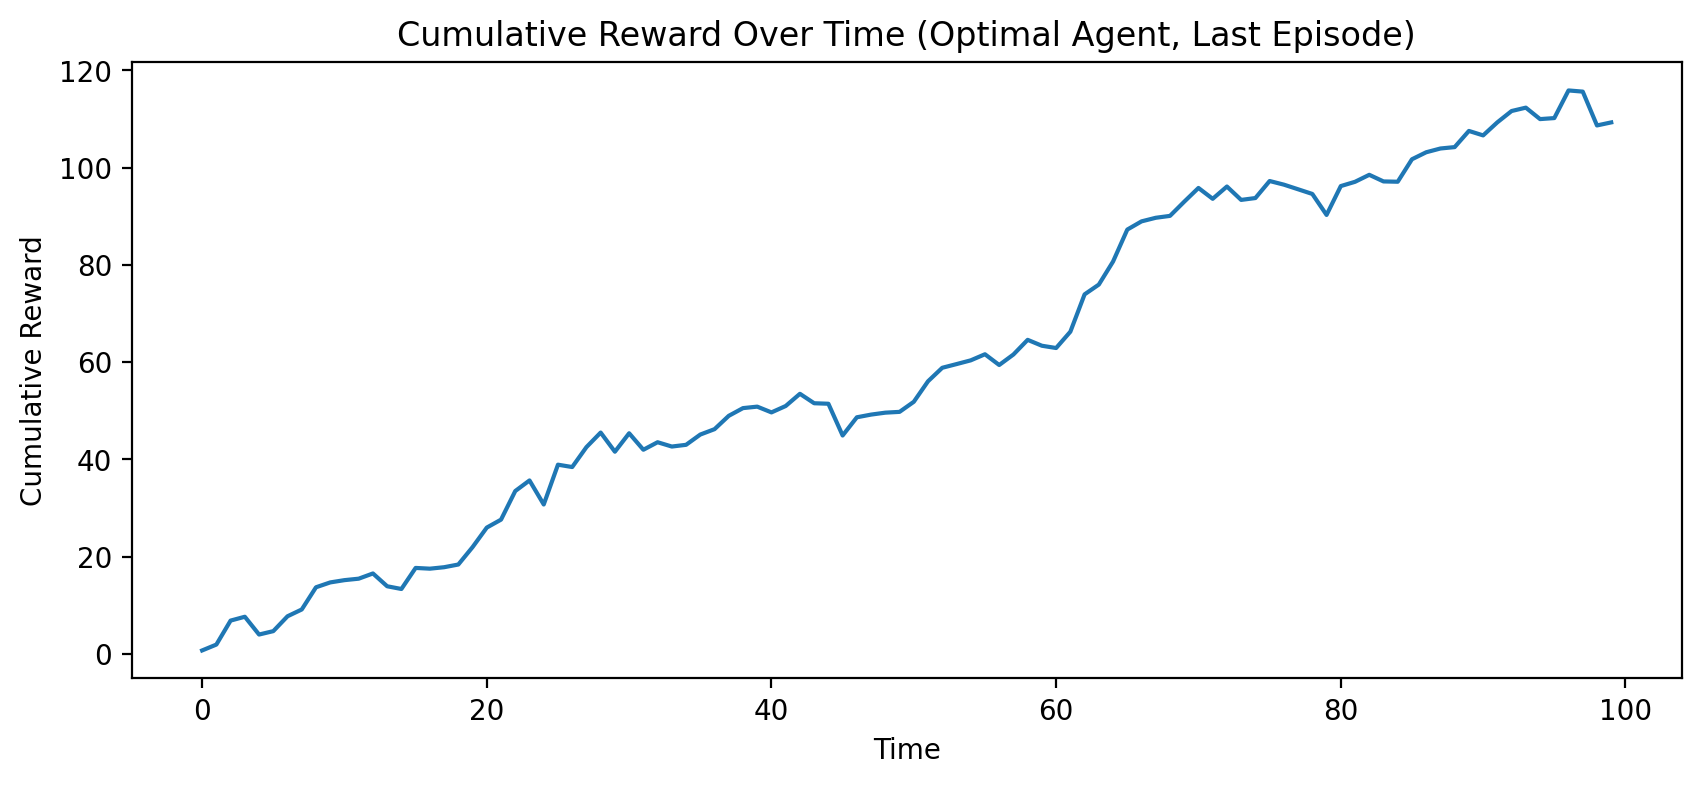

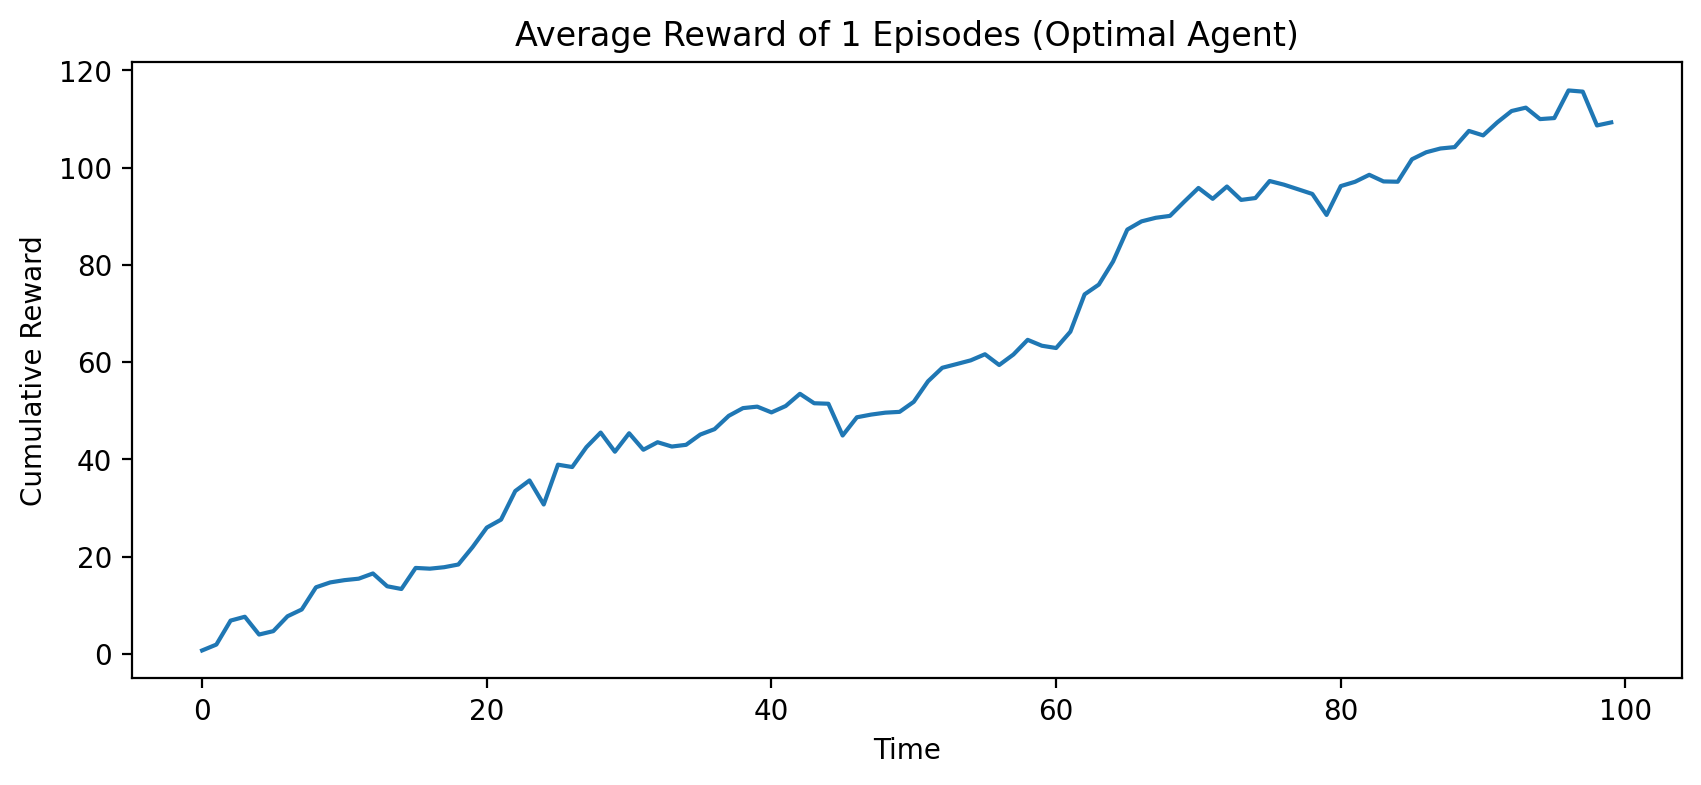

In [11]:
logs_opt, final_rewards_opt, average_rewards_opt = multiple_experiment(
    agent_name='Optimal Agent', agent=agent_optimal, env=env, num_episodes=1,
    show_each=False, show_last=True, show_average=True)

## PPO

In [20]:
state_dim = 2
action_dim = 2
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99
K_epochs = 4
eps_clip = 0.2

In [21]:
ppo_agent = PPO(state_dim, action_dim, lr, betas, gamma, K_epochs, eps_clip)

In [14]:
def train(env, max_episodes, max_timesteps, log_interval):
    memory = Memory()
    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            action = ppo_agent.policy_old.act(state, memory)
            state, reward, done = env.step(action)
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            if done:
                break

        ppo_agent.update(memory)
        memory.clear_memory()

        if i_episode % log_interval == 0:
            print('Episode {} \t Last reward: {}'.format(i_episode, reward))

In [15]:
train(env, max_episodes=500, max_timesteps=500, log_interval=100)

Episode 100 	 Last reward: 3.6270415058558
Episode 200 	 Last reward: 1.0814813760832465
Episode 300 	 Last reward: -4.245169593009109
Episode 400 	 Last reward: 3.3758189479808607
Episode 500 	 Last reward: -5.897153632964432


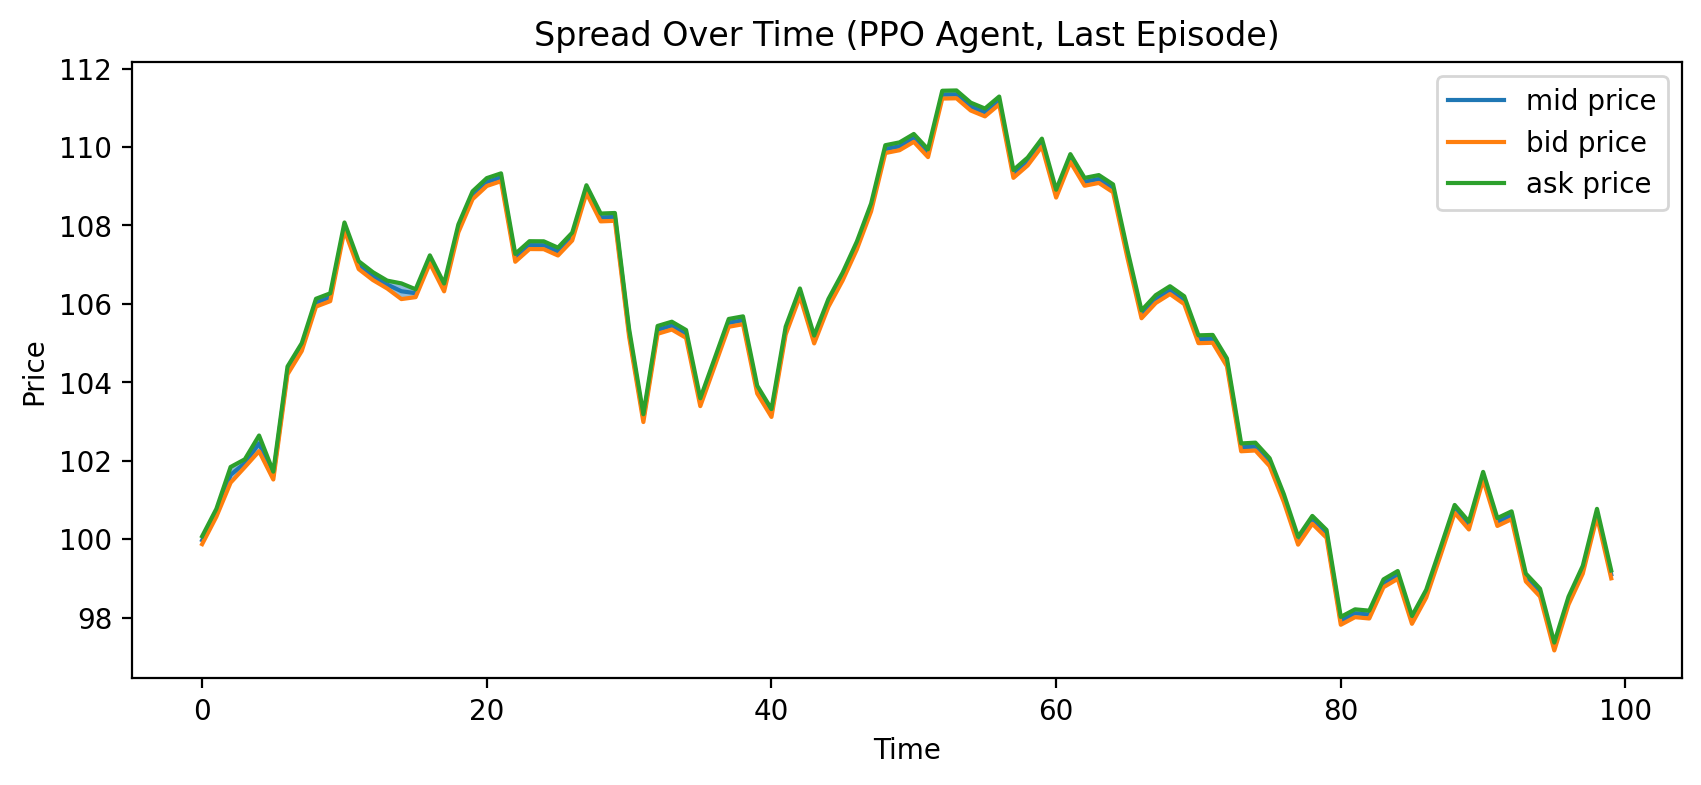

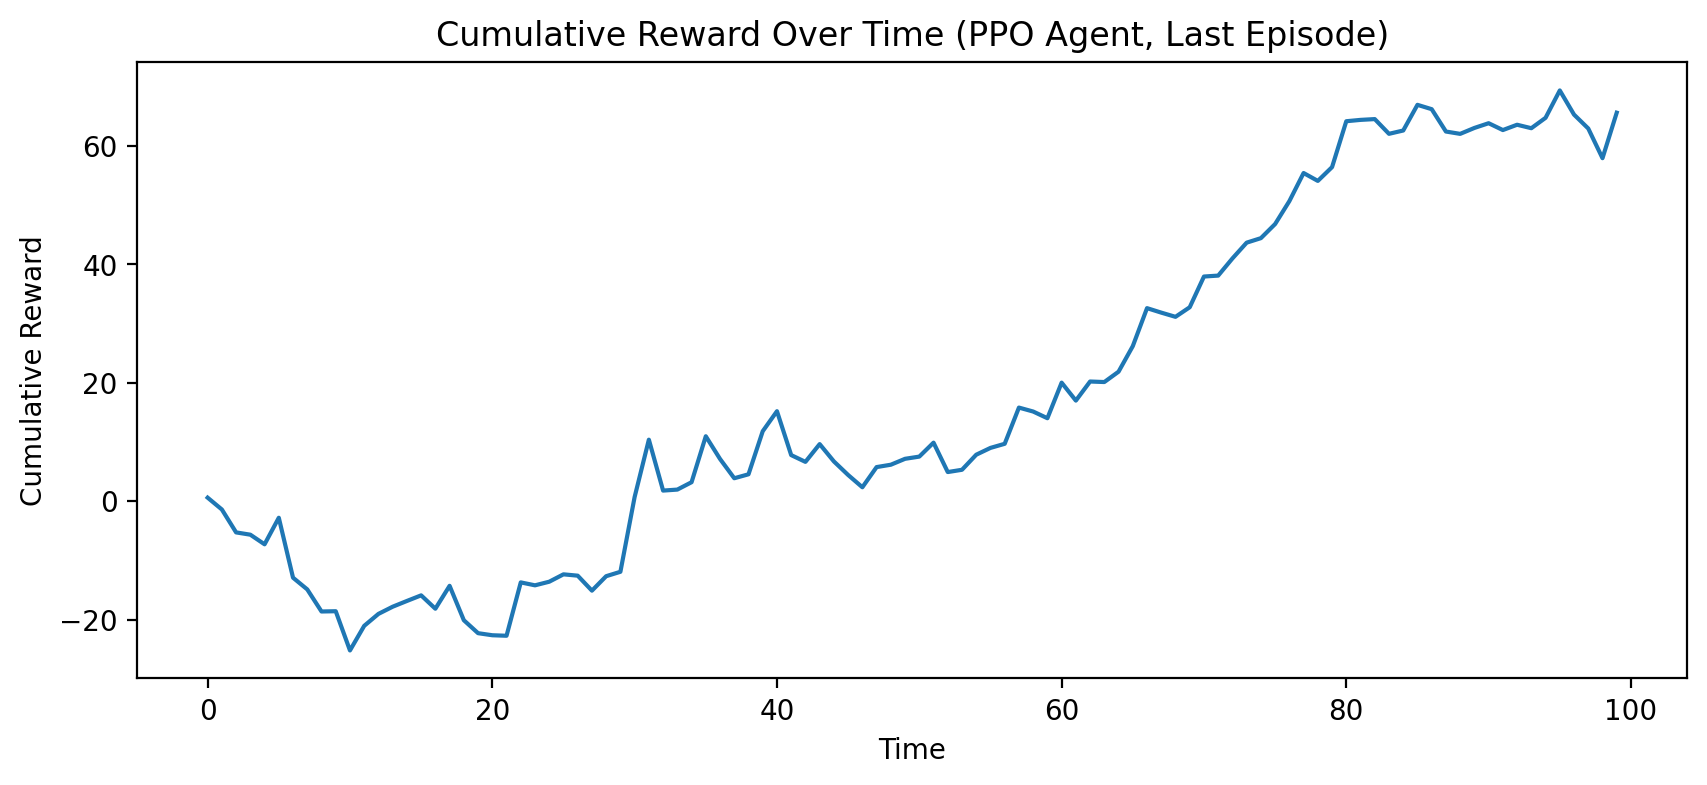

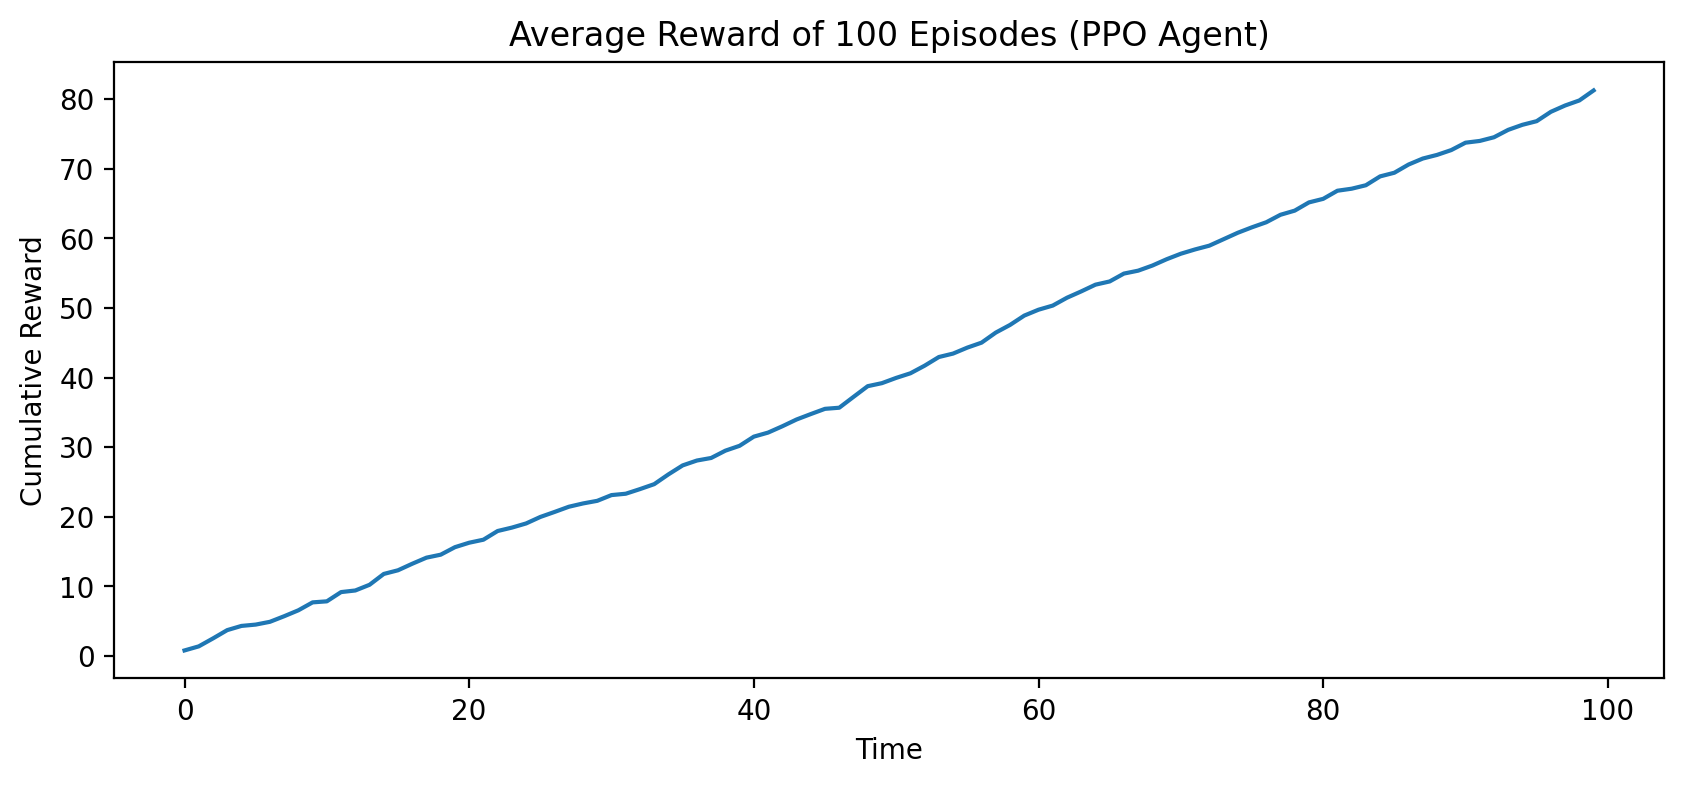

In [22]:
logs_ppo, final_rewards_ppo, average_rewards_ppo = multiple_experiment(
    agent_name='PPO Agent', agent=ppo_agent, env=env, num_episodes=100,
    show_each=False, show_last=True, show_average=True)

### Evaluate

In [23]:
final_rewards = {
    'Random Agent': final_rewards_random,
    'Q-Learning Agent': final_rewards_q,
    'Explore-First Agent': final_rewards_ef,
    'UCB Agent': final_rewards_ucb,
    'Epsilon-Greedy Agent': final_rewards_eg,
    'Decay-Epsilon-Greedy Agent': final_rewards_deg,
    #'Optimal Agent': final_rewards_opt
    'PPO Agent': final_rewards_ppo
}
average_rewards = {
    'Random Agent': average_rewards_random,
    'Q-Learning Agent': average_rewards_q,
    'Explore-First Agent': average_rewards_ef,
    'UCB Agent': average_rewards_ucb,
    'Epsilon-Greedy Agent': average_rewards_eg,
    'Decay-Epsilon-Greedy Agent': average_rewards_deg,
    #'Optimal Agent': average_rewards_opt
    'PPO Agent': average_rewards_ppo
}

In [24]:
final_rewards_df = pd.DataFrame(final_rewards).describe()
final_rewards_df

,Random Agent,Q-Learning Agent,Explore-First Agent,UCB Agent,Epsilon-Greedy Agent,Decay-Epsilon-Greedy Agent,PPO Agent
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,33.307629,65.652995,29.340922,38.801687,40.738103,44.383707,81.248516
std,31.203149,34.579517,36.340958,34.342671,37.318117,39.105084,34.480287
min,-50.376176,-31.458050,-77.717682,-57.799995,-47.837404,-48.889897,-16.575783
25%,13.545611,39.365582,3.127025,14.125679,15.811505,17.942663,62.014094
50%,34.801223,68.393128,27.190497,40.236886,37.982244,43.120909,78.248901
75%,57.897278,93.246201,52.192772,63.483367,68.671650,75.447602,103.302803
max,103.861171,131.091884,175.712779,118.229096,124.553119,125.805789,154.706095


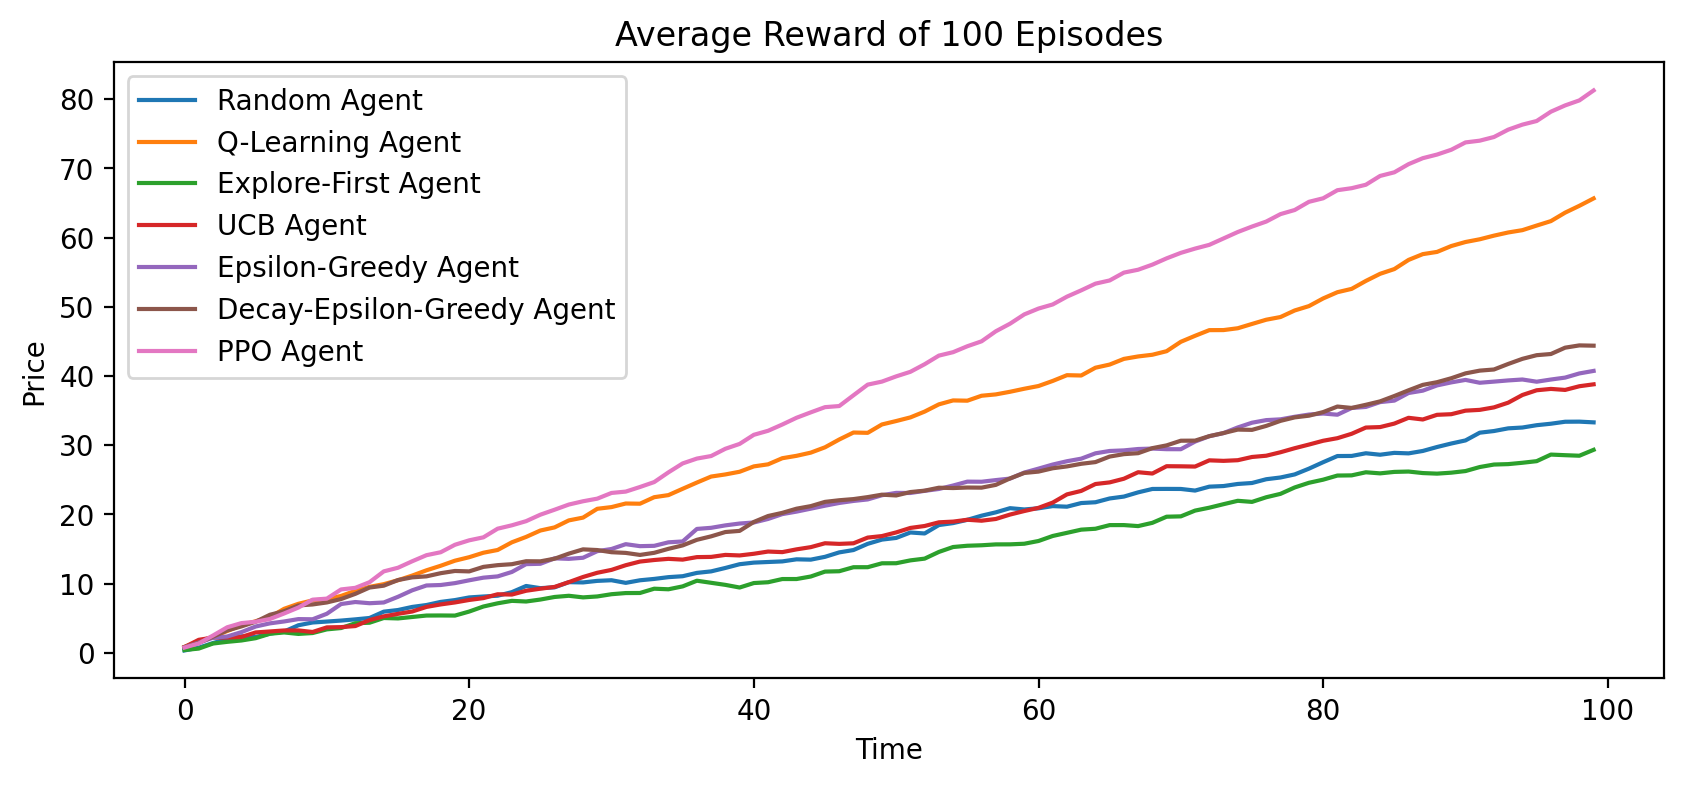

In [25]:
plt.figure(figsize=(10,4), dpi=200)
for agent, avg_reward in average_rewards.items():
    plt.plot(avg_reward, label=agent)
plt.legend()
plt.title(f'Average Reward of 100 Episodes')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()